<h1>Проект: Мультимодальная поисковая система модной одежды<h1>

Этот проект реализует поисковую систему для модных товаров, объединяющую текстовое описание и изображение с помощью модели CLIP (Contrastive Language–Image Pretraining) от OpenAI. 

    
Система поддерживает:

- Поиск по тексту
- Поиск по изображению
- Гибридный поиск (текст + изображение)
- Поиск похожих товаров
- Фильтрацию по атрибутам (цвет, тип, пол и т.д.)
- Векторную базу данных на основе FAISS
- Визуализацию результатов

In [6]:
import os
import sys
import pandas as pd
import numpy as np
from pathlib import Path
import json
import pickle
from typing import List, Dict, Any, Optional, Tuple
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import cv2
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPModel, CLIPProcessor, AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

C:\Users\ejevi\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


###  Загрузка и первичная обработка данных

Этот блок кода выполняет **поиск, загрузку и базовую проверку структуры датасета модной одежды** из Kaggle. Основные шаги:

1. **Скачивание датасета**  
   
   
2. **Исследование структуры папок**  

   Рекурсивно выводится дерево директорий, чтобы понять, где находятся данные.
   

3. **Поиск файлов**  
   - Скрипт ищет все `.csv` файлы (ожидается `styles.csv` — основной файл с описаниями товаров)
   - Также ищет изображения (`*.jpg`) для последующей работы с визуальными данными


4. **Загрузка метаданных**  
   - Пробует найти `styles.csv` (основной источник информации о товарах)
   - Если файл найден — загружает его с обработкой возможных ошибок кодировки (`UTF-8`, `latin-1`, `ISO-8859-1`)
   - Выводит первые строки и список колонок для проверки


In [7]:
#Исследуем структуру датасета
import kagglehub

# Скачиваем датасет
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-dataset")
print(f" Путь к датасету: {path}")

# Рекурсивно просматриваем структуру
def explore_directory(dir_path, indent=0):
    """Рекурсивно просматриваем директорию"""
    dir_path = Path(dir_path)
    
    if dir_path.is_dir():
        items = list(dir_path.iterdir())
        
        for item in items:
            if item.is_dir():
                explore_directory(item, indent + 1)
     
    else:
        print(f"Директория не существует: {dir_path}")

DATA_PATH = Path(path) # Смотрим структуру

explore_directory(DATA_PATH)

 Путь к датасету: C:\Users\ejevi\.cache\kagglehub\datasets\paramaggarwal\fashion-product-images-dataset\versions\1


In [8]:
# Находим правильный путь к данным
# Рекурсивный поиск файлов
def find_files(directory, pattern):
    """Находим файлы по шаблону"""
    directory = Path(directory)
    return list(directory.rglob(pattern))

# Ищем CSV файлы
csv_files = find_files(DATA_PATH, "*.csv")
print(f"📊 Найдено CSV файлов: {len(csv_files)}")
for csv in csv_files[:10]:  # Показываем первые 10
    print(f"  - {csv}")

# Ищем изображения
image_files = find_files(DATA_PATH, "*.jpg")
print(f"\n🖼️ Найдено JPG файлов: {len(image_files)}")
if image_files:
    print(f"  Пример: {image_files[0]}")

📊 Найдено CSV файлов: 4
  - C:\Users\ejevi\.cache\kagglehub\datasets\paramaggarwal\fashion-product-images-dataset\versions\1\fashion-dataset\images.csv
  - C:\Users\ejevi\.cache\kagglehub\datasets\paramaggarwal\fashion-product-images-dataset\versions\1\fashion-dataset\styles.csv
  - C:\Users\ejevi\.cache\kagglehub\datasets\paramaggarwal\fashion-product-images-dataset\versions\1\fashion-dataset\fashion-dataset\images.csv
  - C:\Users\ejevi\.cache\kagglehub\datasets\paramaggarwal\fashion-product-images-dataset\versions\1\fashion-dataset\fashion-dataset\styles.csv

🖼️ Найдено JPG файлов: 88882
  Пример: C:\Users\ejevi\.cache\kagglehub\datasets\paramaggarwal\fashion-product-images-dataset\versions\1\fashion-dataset\fashion-dataset\images\10000.jpg


In [7]:
# Находим styles.csv
styles_csv = None
for csv in csv_files:
    if 'styles' in str(csv).lower():
        styles_csv = csv
        break

if styles_csv:
    print(f"Найден файл со стилями: {styles_csv}")
    styles_df = pd.read_csv(styles_csv, on_bad_lines='skip')
    print(f"Загружено строк: {len(styles_df)}")
else:
    print("Файл styles.csv не найден")
    
    
if 'styles_df' in locals():
    print(f"\n Структура данных ({len(styles_df)} строк, {len(styles_df.columns)} колонок):")
    print(styles_df.head())
    print(f"\n Колонки: {list(styles_df.columns)}")
else:
    print(" Не удалось загрузить данные. Используем альтернативный подход...")
    
    # Создаем демо-датафрейм    
    # Создаем датафрейм из имен файлов
    image_data = []
    for img_path in image_files[:1000]:  # Берем первые 1000 изображений
        product_id = img_path.stem
        image_data.append({
            'product_id': product_id,
            'image_path': str(img_path),
            'display_name': f"Fashion Product {product_id}",
            'article_type': 'Clothing',
            'color': 'Various',
            'season': 'All Season',
            'usage': 'Casual',
            'gender': 'Unisex'
        })
    
    styles_df = pd.DataFrame(image_data)
    print(f" Создан демо-датафрейм: {len(styles_df)} товаров")

Найден файл со стилями: C:\Users\ejevi\.cache\kagglehub\datasets\paramaggarwal\fashion-product-images-dataset\versions\1\fashion-dataset\styles.csv
Загружено строк: 44424

 Структура данных (44424 строк, 10 колонок):
      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid

In [10]:
# Предобработка данных
column_mapping = {
    'id': 'product_id',
    'articleType': 'article_type',
    'baseColour': 'color',
    'productDisplayName': 'display_name',
    'season': 'season',
    'usage': 'usage',
    'gender': 'gender'
}

# Применяем переименование
for old_name, new_name in column_mapping.items():
    if old_name in styles_df.columns and new_name not in styles_df.columns:
        styles_df = styles_df.rename(columns={old_name: new_name})

# Заполняем пропуски
for col in ['season', 'usage', 'gender']:
    if col in styles_df.columns:
        styles_df[col] = styles_df[col].fillna('Unknown')
    else:
        styles_df[col] = 'Unknown'

# Создаем текстовые описания
def create_product_description(row):
    """Создание описания товара"""
    parts = []
    
    if pd.notna(row.get('display_name')) and str(row['display_name']).strip():
        parts.append(str(row['display_name']).strip())
    
    if pd.notna(row.get('article_type')) and str(row['article_type']).strip() not in ['Unknown', '']:
        parts.append(f"{row['article_type']}")
    
    if pd.notna(row.get('color')) and str(row['color']).strip() not in ['Unknown', '']:
        parts.append(f"in {row['color']} color")
    
    if pd.notna(row.get('season')) and str(row['season']).strip() not in ['Unknown', '']:
        parts.append(f"for {row['season']}")
    
    if pd.notna(row.get('usage')) and str(row['usage']).strip() not in ['Unknown', '']:
        parts.append(f"ideal for {row['usage']}")
    
    if pd.notna(row.get('gender')) and str(row['gender']).strip() not in ['Unknown', 'Unisex', '']:
        parts.append(f"for {row['gender']}")
    
    return ", ".join(parts) if parts else "Fashion item"

styles_df['full_description'] = styles_df.apply(create_product_description, axis=1)
styles_df['search_text'] = styles_df.apply(
    lambda x: f"{x.get('display_name', '')} {x.get('article_type', '')} {x.get('color', '')}".strip(),
    axis=1
)

print(f" Обработано: {len(styles_df)} товаров")
print("\n Примеры описаний:")
for i, desc in enumerate(styles_df['full_description'].head(3)):
    print(f"{i+1}. {desc}")

 Обработано: 44424 товаров

 Примеры описаний:
1. Turtle Check Men Navy Blue Shirt, Shirts, in Navy Blue color, for Fall, ideal for Casual, for Men
2. Peter England Men Party Blue Jeans, Jeans, in Blue color, for Summer, ideal for Casual, for Men
3. Titan Women Silver Watch, Watches, in Silver color, for Winter, ideal for Casual, for Women


### Сопоставление изображений с товарами

Этот блок выполняет быстрое сопоставление изображений с записями о товарах:

1. **Собирает все изображения** (`.jpg`, `.jpeg`, `.png`) из датасета в один словарь, где ключ — имя файла без расширения (`product_id`), а значение — полный путь к изображению.


2. **Формирует рабочую выборку** из 1500 случайных товаров.


3. **Ищет изображение для каждого товара**


4. **Выводит статистику**: сколько товаров имеют изображения, сколько — нет, и общий объём данных.

In [12]:
# Собираем все изображения один раз
all_image_files = list(DATA_PATH.rglob("*.jpg")) + list(DATA_PATH.rglob("*.jpeg")) + list(DATA_PATH.rglob("*.png"))
print(f" Всего найдено изображений: {len(all_image_files)}")

# Создаем словарь для быстрого поиска
image_dict = {}
for img_path in all_image_files:
    product_id = str(img_path.stem)  
    image_dict[product_id] = str(img_path)

print(f" Создан словарь изображений: {len(image_dict)} записей")

# Берем подвыборку для демонстрации (1500 товаров для скорости)
SAMPLE_SIZE = min(1500, len(styles_df))
work_df = styles_df.sample(SAMPLE_SIZE, random_state=42).copy()
work_df['product_id'] = work_df['product_id'].astype(str)

def fast_find_image(product_id):
    """Быстрый поиск изображения по ID """
    if not isinstance(product_id, str):
        product_id = str(product_id)
    
    # Пробуем разные варианты ID
    variants = [product_id]
    
    # Если есть подчеркивание, пробуем часть до него
    if '_' in product_id:
        variants.append(product_id.split('_')[0])
    
    # Пробуем удалить ведущие нули
    if product_id.isdigit():
        variants.append(str(int(product_id)))
    
    for variant in variants:
        if variant and variant in image_dict:
            return image_dict[variant]
    
    # Если не нашли, ищем по частичному совпадению
    for key in image_dict:
        if product_id in key or key in product_id:
            return image_dict[key]
    
    return None

# Применяем быструю функцию
work_df['image_path'] = work_df['product_id'].apply(fast_find_image)
work_df['has_image'] = work_df['image_path'].notna()
images_found = work_df['has_image'].sum()
print(f" Изображений найдено: {images_found}/{len(work_df)} ({images_found/len(work_df)*100:.1f}%)")

# Показываем статистику
print("\n Статистика выборки:")
print(f"  - Всего товаров: {len(work_df)}")
print(f"  - С реальными изображениями: {images_found}")
print(f"  - С демо-изображениями: {len(work_df) - images_found}")
print(f"  - Размер выборки: {work_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Показываем несколько примеров
print("\n Примеры найденных изображений:")
found_samples = work_df[work_df['image_path'].notna() & (~work_df['image_path'].str.startswith('demo_'))].head(3)

if len(found_samples) > 0:
    for i, (_, row) in enumerate(found_samples.iterrows()):
        print(f"{i+1}. ID: {row['product_id']}")
        print(f"   Название: {row['display_name'][:50]}...")
        print(f"   Путь: {Path(row['image_path']).name}")        

 Всего найдено изображений: 88882
 Создан словарь изображений: 44441 записей
 Изображений найдено: 1500/1500 (100.0%)

 Статистика выборки:
  - Всего товаров: 1500
  - С реальными изображениями: 1500
  - С демо-изображениями: 0
  - Размер выборки: 1.52 MB

 Примеры найденных изображений:
1. ID: 12532
   Название: Puma Women Solid Black Jackets...
   Путь: 12532.jpg
2. ID: 3469
   Название: ADIDAS Unisex Black White Headband...
   Путь: 3469.jpg
3. ID: 24742
   Название: Murcia Women Casual Handbag...
   Путь: 24742.jpg


### Энкодер на основе CLIP

Реализован класс `FashionCLIPEncoder`, который использует предобученную модель CLIP (Contrastive Language–Image Pretraining) от OpenAI для генерации эмбеддингов:

- **`encode_text(text)`** — преобразует текстовое описание товара в 512-мерный вектор.
- **`encode_image(path)`** — загружает изображение, приводит его к размеру 224×224 и создаёт соответствующий вектор признаков.  
- **`encode_product(...)`** — комбинирует текст и изображение.

In [13]:
class FashionCLIPEncoder:
    """Энкодер для модных товаров на основе CLIP"""
    
    def __init__(self, device=None):
        
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.model.to(self.device)
        self.model.eval()
        
        print(" Модель загружена")
    
    def encode_image(self, image_input):
        """Кодирование изображения"""
        try:
            if isinstance(image_input, str):
                if image_input == 'demo_image':
                    # Создаем демо-изображение
                    demo_img = Image.new('RGB', (224, 224), color='gray')
                    image = demo_img
                else:
                    image = Image.open(image_input).convert('RGB')
            elif isinstance(image_input, Image.Image):
                image = image_input
            else:
                return None
            
            image = image.resize((224, 224))

            inputs = self.processor(images=image, return_tensors="pt")
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            
            with torch.no_grad():
                features = self.model.get_image_features(**inputs)
                features = F.normalize(features, p=2, dim=-1)
            
            return features.cpu().numpy()
        
        except Exception as e:
            print(f" Ошибка кодирования изображения: {e}")
            return None
    
    def encode_text(self, text):
        """Кодирование текста"""
        
        inputs = self.processor(text=str(text), return_tensors="pt", 
                               padding=True, truncation=True, max_length=77)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        
        with torch.no_grad():
            features = self.model.get_text_features(**inputs)
            features = F.normalize(features, p=2, dim=-1)
        
        return features.cpu().numpy()
    
    def encode_product(self, text_description, image_path=None):
        """Кодирование товара"""
        embeddings = {}
        
        # Текстовый эмбеддинг
        text_emb = self.encode_text(text_description)
        if text_emb is not None:
            embeddings['text'] = text_emb.flatten()
        
        # Изображение если есть
        if image_path:
            img_emb = self.encode_image(image_path)
            if img_emb is not None:
                embeddings['image'] = img_emb.flatten()
        
        # Комбинированный эмбеддинг
        if 'text' in embeddings and 'image' in embeddings:
            combined = (embeddings['text'] + embeddings['image']) / 2
            embeddings['combined'] = combined
        
        return embeddings

# Инициализируем энкодер
encoder = FashionCLIPEncoder()

 Модель загружена


### Генерация и сохранение мультимодальных эмбеддингов

На этом этапе система:

1. **Проходит по всем товарам** из рабочей выборки:
   - Извлекает текстовое описание (`full_description`)
   - Получает путь к изображению (или `None`, если его нет)
   - Генерирует мультимодальный эмбеддинг с помощью CLIP-энкодера 
   
   
2. **Сохраняет три ключевых компонента** в отдельные файлы:
   - `embeddings.pkl` — словарь `{product_id → combined embedding}`
   - `metadata.pkl` — человекочитаемые атрибуты товара (название, цвет, тип и т.д.)
   - `image_paths.pkl` — маппинг `{product_id → путь_к_изображению}`

In [14]:
print("\n Генерация эмбеддингов для товаров...")

EMBEDDINGS_DIR = Path("./fashion_embeddings_real")
EMBEDDINGS_DIR.mkdir(exist_ok=True)

# Словари для хранения данных
all_embeddings = {}
product_metadata = {}
image_paths_dict = {}

for idx, row in tqdm(work_df.iterrows(), total=len(work_df), desc="Генерация эмбеддингов"):
    product_id = row['product_id']
    description = row['full_description']
    image_path = row['image_path'] if row['has_image'] else None
    
    try:
        # Генерируем эмбеддинги
        embeddings = encoder.encode_product(description, image_path)
        
        if embeddings and 'combined' in embeddings:
            all_embeddings[product_id] = embeddings['combined']
            
            # Сохраняем метаданные
            product_metadata[product_id] = {
                'product_id': product_id,
                'display_name': row['display_name'],
                'article_type': row.get('article_type', 'Unknown'),
                'color': row.get('color', 'Unknown'),
                'season': row.get('season', 'Unknown'),
                'usage': row.get('usage', 'Unknown'),
                'gender': row.get('gender', 'Unknown'),
                'description': description,
                'search_text': row['search_text']
            }
            
            if image_path:
                image_paths_dict[product_id] = image_path
    
    except Exception as e:
        print(f"\n Ошибка для товара {product_id}: {e}")
        continue

print(f"\n✅ Успешно обработано: {len(all_embeddings)} товаров")

# Сохраняем данные
print("\n💾 Сохраняем данные...")
with open(EMBEDDINGS_DIR / "embeddings.pkl", "wb") as f:
    pickle.dump(all_embeddings, f)

with open(EMBEDDINGS_DIR / "metadata.pkl", "wb") as f:
    pickle.dump(product_metadata, f)

with open(EMBEDDINGS_DIR / "image_paths.pkl", "wb") as f:
    pickle.dump(image_paths_dict, f)

print("💾 Данные сохранены!")

Генерация эмбеддингов:   0%|                                                                  | 0/1500 [00:00<?, ?it/s]


 Генерация эмбеддингов для товаров...


Генерация эмбеддингов: 100%|███████████████████████████████████████████████████████| 1500/1500 [09:11<00:00,  2.72it/s]


✅ Успешно обработано: 1500 товаров

💾 Сохраняем данные...
💾 Данные сохранены!


###  Поисковая система на основе мультимодальных эмбеддингов

Класс `FashionSearchEngine` предоставляет единый интерфейс для поиска модных товаров с использованием предварительно вычисленных CLIP-эмбеддингов и FAISS-индекса. Основные возможности:

- **`search_by_text(query)`** — поиск по текстовому описанию 
- **`search_by_image(path)`** — визуальный поиск по загруженному изображению
- **`search_hybrid(text, image_path)`** — комбинированный поиск, объединяющий текст и изображение
- **`get_similar_products(product_id)`** — поиск товаров, похожих на указанный (по его эмбеддингу)



⚙️ Инициализация поисковой системы...
 Модель загружена
 Энкодер загружен
Пути к изображениям: 1500 записей
🎉 Поисковая система готова к работе!

 Быстрый тест поисковой системы...
 Система готова: 1500 товаров в индексе
🔍 Поиск: 'dress' (топ-3)
 Поиск работает! Найдено 3 результатов


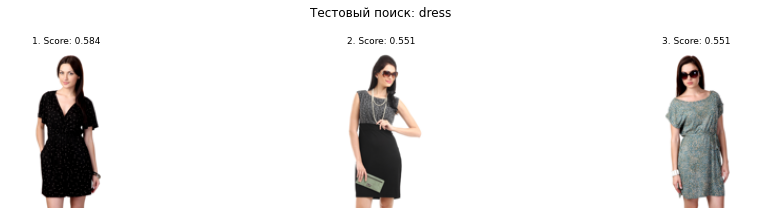


1. French Connection Black Dress
   📍 ID: 48469
   🎨 Цвет: Black
   👕 Тип: Dresses
   ⭐ Сходство: 0.584

2. Avirate Black Formal Dress
   📍 ID: 59994
   🎨 Цвет: Black
   👕 Тип: Dresses
   ⭐ Сходство: 0.551

3. French Connection Women Green Dress
   📍 ID: 48486
   🎨 Цвет: Green
   👕 Тип: Dresses
   ⭐ Сходство: 0.551


In [15]:
class FashionSearchEngine:
    """Полнофункциональная поисковая система для моды"""
    
    def __init__(self, embeddings_dir="./fashion_embeddings_real", data_path=None):
        self.embeddings_dir = Path(embeddings_dir)
        self.data_path = Path(data_path) if data_path else DATA_PATH

        self.encoder = FashionCLIPEncoder()
        print(" Энкодер загружен")
        
        #Загружаем FAISS индекс
        
        index_path = self.embeddings_dir / "faiss_index.bin"
        if index_path.exists():
            self.index = faiss.read_index(str(index_path))
        else:
            self.index = None
            return
        
        metadata_path = self.embeddings_dir / "metadata.pkl"
        if metadata_path.exists():
            with open(metadata_path, "rb") as f:
                self.metadata = pickle.load(f)
        else:
            self.metadata = {}
        
        #Загружаем маппинг
        
        mapping_path = self.embeddings_dir / "index_mapping.pkl"
        if mapping_path.exists():
            with open(mapping_path, "rb") as f:
                self.index_mapping = pickle.load(f)
        
            self.product_to_index = {pid: idx for idx, pid in self.index_mapping.items()}
        else:
            self.index_mapping = {}
            self.product_to_index = {}
        
        #Загружаем пути к изображениям
        
        image_paths_path = self.embeddings_dir / "image_paths.pkl"
        if image_paths_path.exists():
            with open(image_paths_path, "rb") as f:
                self.image_paths = pickle.load(f)
            print(f"Пути к изображениям: {len(self.image_paths)} записей")
        else:
        
            self.image_paths = {}
        
        print("🎉 Поисковая система готова к работе!")
    
    def search_by_text(self, query, top_k=10, filters=None):
        """Поиск по текстовому запросу"""
        if not self.index:
            return []
        
        print(f"🔍 Поиск: '{query}' (топ-{top_k})")
        
        # Кодируем запрос
        query_emb = self.encoder.encode_text(query)
        if query_emb is None:
      
            return []
        
        return self._search_with_embedding(query_emb, top_k, filters)
    
    def search_by_image(self, image_path, top_k=10, filters=None):
        """Поиск по изображению"""
        if not self.index:
            return []
        
        print(f"🔍 Поиск по изображению: {Path(image_path).name} (топ-{top_k})")
        
        # Проверяем существование файла
        if not Path(image_path).exists():
            return []
        
        # Кодируем изображение
        query_emb = self.encoder.encode_image(image_path)
        if query_emb is None:
       
            return []
        
        return self._search_with_embedding(query_emb, top_k, filters)
    
    def search_hybrid(self, text=None, image_path=None, top_k=10, filters=None):
        """Гибридный поиск (текст + изображение)"""
        if not self.index:
            return []
        
        print(f"🔍 Гибридный поиск (топ-{top_k})")
        
        embeddings = []
        
        if text:
            text_emb = self.encoder.encode_text(text)
            if text_emb is not None:
                embeddings.append(text_emb)
                print(f" Текстовый запрос: '{text}'")
        
        if image_path and Path(image_path).exists():
            img_emb = self.encoder.encode_image(image_path)
            if img_emb is not None:
                embeddings.append(img_emb)
                print(f" Изображение: {Path(image_path).name}")
        
        if not embeddings:
            return []
        
        # Усредняем эмбеддинги
        query_emb = np.mean(embeddings, axis=0)
        
        return self._search_with_embedding(query_emb, top_k, filters)
    
    def _search_with_embedding(self, query_embedding, top_k, filters):
        """Внутренний метод поиска по эмбеддингу"""

        query_embedding = query_embedding.astype('float32')
        faiss.normalize_L2(query_embedding)
        
        search_k = min(top_k * 5, self.index.ntotal)
        
        # Выполняем поиск в FAISS
        distances, indices = self.index.search(query_embedding, search_k)
        
        results = []
        seen_products = set()
        
        for dist, idx in zip(distances[0], indices[0]):
            if idx == -1:  
                continue
            
            # Получаем ID товара
            product_id = self.index_mapping.get(idx)
            if not product_id or product_id in seen_products:
                continue
            
            seen_products.add(product_id)
            
            # Получаем метаданные
            metadata = self.metadata.get(product_id, {}).copy()
            
            # Применяем фильтры
            if filters and not self._apply_filters(metadata, filters):
                continue
            
            # Добавляем результат
            results.append({
                'product_id': product_id,
                'similarity': float(dist),
                'metadata': metadata
            })
            
            if len(results) >= top_k:
                break
        
        return results
    
    def _apply_filters(self, metadata, filters):
        """Применение фильтров к результатам"""
        for key, value in filters.items():
            if key in metadata:
                if isinstance(value, list):
                    if metadata[key] not in value:
                        return False
                elif str(metadata[key]).lower() != str(value).lower():
                    return False
        return True
    
    def get_similar_products(self, product_id, top_k=5):
        """Поиск товаров, похожих на указанный"""
        if not self.index or product_id not in self.product_to_index:
            return []
        
        idx = self.product_to_index[product_id]
        
        # Получаем эмбеддинг товара
        if hasattr(self.index, 'reconstruct'):
            try:
                product_emb = self.index.reconstruct(idx)
                product_emb = product_emb.reshape(1, -1).astype('float32')
                faiss.normalize_L2(product_emb)
                
                # Ищем похожие (берем на 1 больше чтобы пропустить сам товар)
                distances, indices = self.index.search(product_emb, top_k + 1)
                
                results = []
                for i, (dist, idx2) in enumerate(zip(distances[0], indices[0])):
                    if i == 0:  # Пропускаем сам товар
                        continue
                    
                    similar_id = self.index_mapping.get(idx2)
                    if similar_id:
                        metadata = self.metadata.get(similar_id, {}).copy()
                        results.append({
                            'product_id': similar_id,
                            'similarity': float(dist),
                            'metadata': metadata
                        })
                
                return results
            except Exception as e:
                return []
        
        return []
    
    def get_product_image(self, product_id, size=(200, 200)):
        """Получение изображения товара """
        if product_id in self.image_paths:
            img_path = self.image_paths[product_id]
            if Path(img_path).exists():
                try:
                    img = Image.open(img_path).convert('RGB')
     
                    img.thumbnail(size)
                    return img
                except Exception as e:
                    print(f" Ошибка загрузки сохраненного изображения {product_id}: {e}")
        
        for ext in ['.jpg', '.jpeg', '.png']:
            pattern = f"*{product_id}*{ext}"
            matches = list(self.data_path.rglob(pattern))
            if matches:
                try:
                    img = Image.open(matches[0]).convert('RGB')
                    img.thumbnail(size)
                    return img
                except Exception as e:
                    continue
        
        placeholder = Image.new('RGB', size, color='#f0f0f0')
        return placeholder
    
    def display_results(self, results, title="Результаты поиска"):
        """Красивое отображение результатов"""
        
        for i, result in enumerate(results, 1):
            metadata = result['metadata']
            product_id = result['product_id']
            
            print(f"\n{i}. [{product_id}] {metadata.get('display_name', 'No name')}")
            print(f"   📝 Описание: {metadata.get('description', 'No description')[:80]}...")
            print(f"   🎨 Цвет: {metadata.get('color', 'Unknown')}")
            print(f"   👕 Тип: {metadata.get('article_type', 'Unknown')}")
            print(f"   👤 Пол: {metadata.get('gender', 'Unknown')}")
            print(f"   ⭐ Сходство: {result['similarity']:.3f}")
        
        print(f"📊 Всего найдено: {len(results)} товаров")
    
    def visualize_results(self, results, title="Результаты поиска"):
        """Визуализация результатов с изображениями"""
      
        n_cols = min(5, len(results))
        fig, axes = plt.subplots(1, n_cols, figsize=(15, 3))
        
        if n_cols == 1:
            axes = [axes]
        
        for idx, (ax, result) in enumerate(zip(axes, results[:n_cols])):
            product_id = result['product_id']
            
            # Загружаем изображение
            img = self.get_product_image(product_id, size=(150, 150))
            ax.imshow(img)
         
            score = result['similarity']
            ax.set_title(f"{idx+1}. Score: {score:.3f}", fontsize=9)
            ax.axis('off')
        
        plt.suptitle(title, fontsize=12)
        plt.tight_layout()
        plt.show()
        
        for i, result in enumerate(results[:3], 1):
            meta = result['metadata']
            print(f"\n{i}. {meta.get('display_name', 'No name')}")
            print(f"   📍 ID: {result['product_id']}")
            print(f"   🎨 Цвет: {meta.get('color', 'Unknown')}")
            print(f"   👕 Тип: {meta.get('article_type', 'Unknown')}")
            print(f"   ⭐ Сходство: {result['similarity']:.3f}")

# Инициализируем поисковую систему
print("\n⚙️ Инициализация поисковой системы...")
search_engine = FashionSearchEngine(embeddings_dir=EMBEDDINGS_DIR)

# Тестируем сразу после инициализации
print("\n Быстрый тест поисковой системы...")

if search_engine.index is None:
    print(" Поисковая система не инициализирована")
else:
    print(f" Система готова: {search_engine.index.ntotal} товаров в индексе")

    test_results = search_engine.search_by_text("dress", top_k=3)
    
    if test_results:
        print(f" Поиск работает! Найдено {len(test_results)} результатов")
        search_engine.visualize_results(test_results, "Тестовый поиск: dress")
    else:
        print(" Поиск не вернул результатов")

 Тестирование всех функций поисковой системы...

🔴 Красное платье:
🔍 Поиск: 'red dress' (топ-2)
  1. Arrow Woman Rima Red Dress
     Сходство: 0.572
  2. W Women Round Bottom Red Kurta
     Сходство: 0.531

⚫ Черная куртка:
🔍 Поиск: 'black jacket' (топ-2)
  1. Just Natural Men Black Reversible Jacket
     Сходство: 0.622
  2. Wildcraft Women Black Jacket
     Сходство: 0.600

🔵 Синие джинсы:
🔍 Поиск: 'blue jeans' (топ-2)
  1. Locomotive Men Washed Blue Jeans
     Сходство: 0.633
  2. Spykar Men Blue Jeans
     Сходство: 0.626

⚪ Белая рубашка:
🔍 Поиск: 'white shirt' (топ-2)
  1. Indigo Nation Men White Shirt
     Сходство: 0.633
  2. Spykar Men Check White Shirts
     Сходство: 0.631

🟢 Зеленые туфли:
🔍 Поиск: 'green shoes' (топ-2)
  1. Grendha Women Claudia Green Flats
     Сходство: 0.586
  2. Fila Men Green Fuel HI Shoes
     Сходство: 0.563

 Черные платья:
🔍 Поиск: 'dress' (топ-2)
  1. French Connection Black Dress
     Цвет: Black
  2. Avirate Black Formal Dress
     Цвет: Black


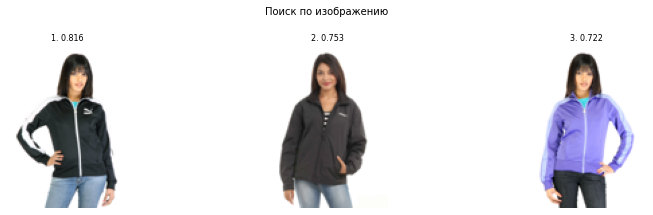

1. Puma Women Solid Black Jackets
   Сходство: 0.816
2. Wildcraft Women Black Jacket
   Сходство: 0.753

 Все тесты завершены!


In [16]:
# Тестирование всех функций системы
print(" Тестирование всех функций поисковой системы...")

if search_engine.index is not None:

    test_queries = [
        ("red dress", "🔴 Красное платье"),
        ("black jacket", "⚫ Черная куртка"), 
        ("blue jeans", "🔵 Синие джинсы"),
        ("white shirt", "⚪ Белая рубашка"),
        ("green shoes", "🟢 Зеленые туфли")
    ]
    
    for query, description in test_queries:
        print(f"\n{description}:")
        results = search_engine.search_by_text(query, top_k=2)
        if results:
        
            for i, result in enumerate(results, 1):
                meta = result['metadata']
                print(f"  {i}. {meta.get('display_name', 'No name')[:40]}")
                print(f"     Сходство: {result['similarity']:.3f}")
    
    # Тест с фильтрами
    filter_tests = [
        ("dress", {"color": "Black"}, " Черные платья"),
        ("shirt", {"gender": "Men"}, " Рубашки для мужчин"),
        ("jacket", {"article_type": "Jackets"}, " Только куртки"),
    ]
    
    for query, filters, description in filter_tests:
        print(f"\n{description}:")
        results = search_engine.search_by_text(query, top_k=2, filters=filters)
        if results:
        
            for i, result in enumerate(results, 1):
                meta = result['metadata']
                print(f"  {i}. {meta.get('display_name', 'No name')[:30]}")
                print(f"     Цвет: {meta.get('color', 'Unknown')}")


    if search_engine.metadata:
        sample_products = list(search_engine.metadata.keys())[:3]
        
        for product_id in sample_products:
            meta = search_engine.metadata[product_id]
            print(f"\n Похожие на: {meta.get('display_name', product_id)[:30]}")
            
            similar = search_engine.get_similar_products(product_id, top_k=2)
            if similar:
                for i, sim in enumerate(similar, 1):
                    sim_meta = sim['metadata']
                    print(f"  {i}. {sim_meta.get('display_name', '')[20]}")
                    print(f"     Сходство: {sim['similarity']:.3f}")
            else:
                print(" Похожие не найдены")
    
    # Находим товар с изображением для теста
    if search_engine.image_paths:
        test_product = list(search_engine.image_paths.keys())[0]
        test_image = search_engine.image_paths[test_product]
        
        if Path(test_image).exists():
            print(f"🔍 Поиск по изображению товара: {test_product}")
            results = search_engine.search_by_image(test_image, top_k=3)
            
            if results:
                print(f" Найдено {len(results)} похожих товаров")
                # Показываем миниатюры
                n_cols = min(3, len(results))
                fig, axes = plt.subplots(1, n_cols, figsize=(12, 3))
                
                if n_cols == 1:
                    axes = [axes]
                
                for idx, (ax, result) in enumerate(zip(axes, results[:n_cols])):
                    img = search_engine.get_product_image(result['product_id'], size=(120, 120))
                    ax.imshow(img)
                    ax.set_title(f"{idx+1}. {result['similarity']:.3f}", fontsize=8)
                    ax.axis('off')
                
                plt.suptitle(f"Поиск по изображению", fontsize=10)
                plt.tight_layout()
                plt.show()
                
                # Текстовая информация
                for i, result in enumerate(results[:2], 1):
                    meta = result['metadata']
                    print(f"{i}. {meta.get('display_name', 'No name')}")
                    print(f"   Сходство: {result['similarity']:.3f}")
            else:
                print(" Результаты не найдены")
        else:
            print(" Тестовое изображение не найдено")
    
    print("\n Все тесты завершены!")
else:
    print(" Система не инициализирована")

🔍 Поиск по изображению: 12532.jpg (топ-4)
    Товар: Puma Women Solid Black Jackets
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.727


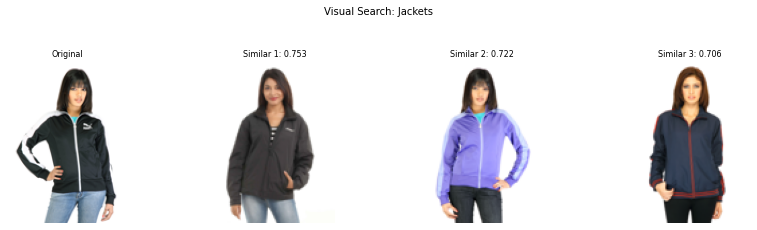

🔍 Поиск по изображению: 46121.jpg (топ-4)
    Товар: Wildcraft Women Black Jacket
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.723
🔍 Поиск по изображению: 59132.jpg (топ-4)
    Товар: Just Natural Men Black Reve...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.720
🔍 Поиск по изображению: 24742.jpg (топ-4)
    Товар: Murcia Women Casual Handbag
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.741


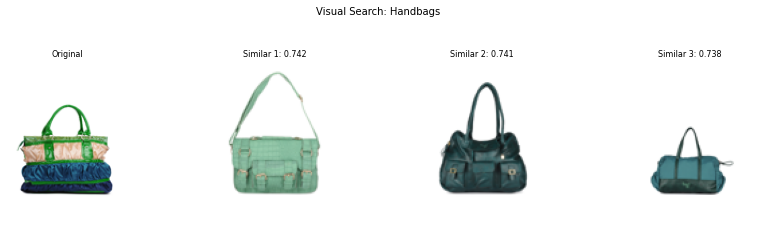

🔍 Поиск по изображению: 42938.jpg (топ-4)
    Товар: French Connection Men Black...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 3/3
      ⭐ Средняя схожесть: 0.737
🔍 Поиск по изображению: 21526.jpg (топ-4)
    Товар: Kiara Women Glossy Red Handbag
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.765
🔍 Поиск по изображению: 28477.jpg (топ-4)
    Товар: Urban Yoga Women Printed Pu...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.751


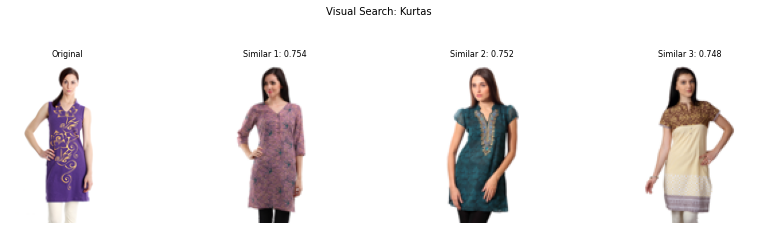

🔍 Поиск по изображению: 39174.jpg (топ-4)
    Товар: Aneri Women Blue Printed Kurta
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.757
🔍 Поиск по изображению: 21885.jpg (топ-4)
    Товар: BIBA Women Printed Green Kurta
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.755
🔍 Поиск по изображению: 9966.jpg (топ-4)
    Товар: Nike Women As Statement Whi...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.725


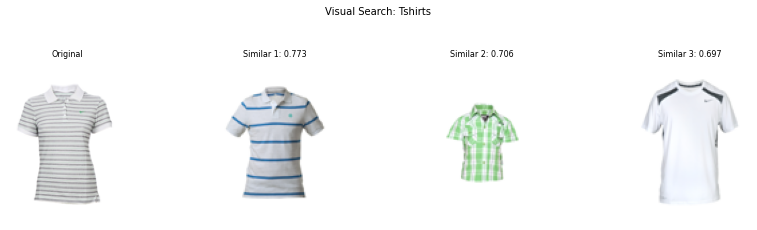

🔍 Поиск по изображению: 43065.jpg (топ-4)
    Товар: Nike Men Grey Striped T-shirt
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.724
🔍 Поиск по изображению: 3125.jpg (топ-4)
    Товар: Inkfruit Men's Star War Bla...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.671
🔍 Поиск по изображению: 58208.jpg (топ-4)
    Товар: New Hide Men Brown Belt
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 3/3
      ⭐ Средняя схожесть: 0.796


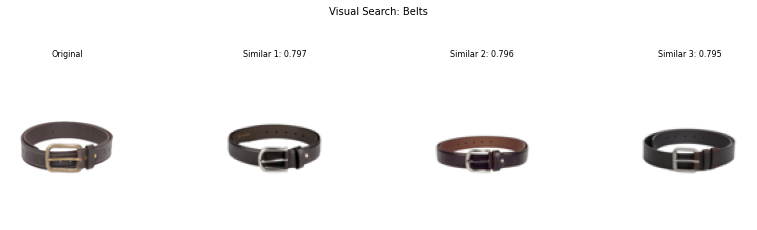

🔍 Поиск по изображению: 25105.jpg (топ-4)
    Товар: Lino Perros Women Black Belt
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.755
🔍 Поиск по изображению: 48118.jpg (топ-4)
    Товар: Fossil Women Brown Sasha Belt
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 3/3
      ⭐ Средняя схожесть: 0.799
🔍 Поиск по изображению: 30591.jpg (топ-4)
    Товар: Nike Unisex Federer Blue Cap
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 3/3
      ⭐ Средняя схожесть: 0.651


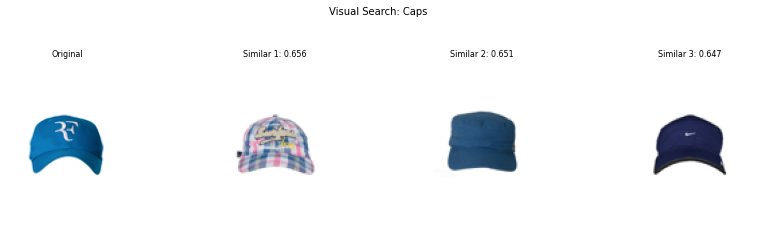

🔍 Поиск по изображению: 19434.jpg (топ-4)
    Товар: Quiksilver Men Blue Sting R...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.732
🔍 Поиск по изображению: 7619.jpg (топ-4)
    Товар: Wrangler Men Light Blue Can...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 3/3
      ⭐ Средняя схожесть: 0.746
🔍 Поиск по изображению: 45627.jpg (топ-4)
    Товар: Park Avenue Men Grey Briefs
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.742


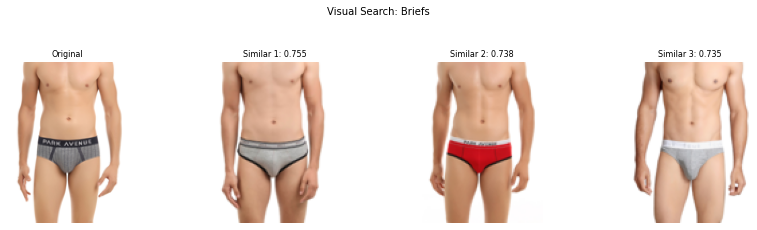

🔍 Поиск по изображению: 53532.jpg (топ-4)
    Товар: Amante Women White Briefs P...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.716
🔍 Поиск по изображению: 31903.jpg (топ-4)
    Товар: Hear 2 Heart Women White Br...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.718
🔍 Поиск по изображению: 50468.jpg (топ-4)
    Товар: Chromozome Men Grey Melange...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.782


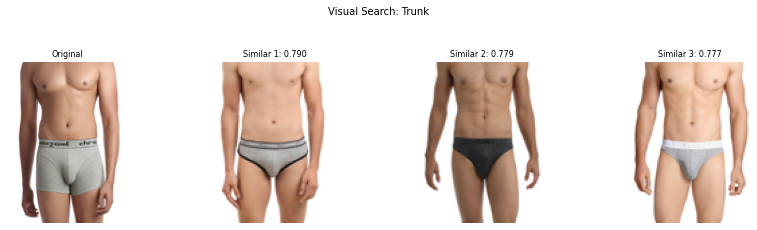

🔍 Поиск по изображению: 17860.jpg (топ-4)
    Товар: Levis Men Boxer Green Trunks
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.772
🔍 Поиск по изображению: 28015.jpg (топ-4)
    Товар: Jockey ZONE STRETCH Men Zon...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.749
🔍 Поиск по изображению: 51797.jpg (топ-4)
    Товар: Bwitch Turquiose Blue Night...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.743


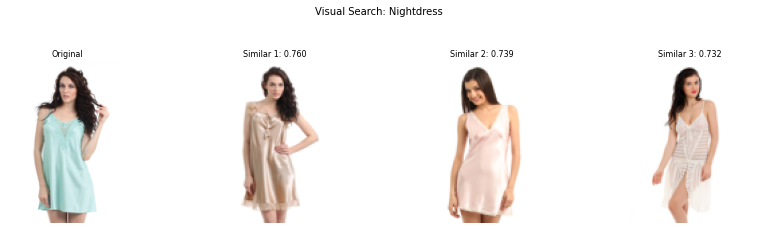

🔍 Поиск по изображению: 50992.jpg (топ-4)
    Товар: Enamor Women Beige Nightdress
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.743
🔍 Поиск по изображению: 52449.jpg (топ-4)
    Товар: Red Rose White Nightdress
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.739
🔍 Поиск по изображению: 31221.jpg (топ-4)
    Товар: Puma Women Black Capris
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.740


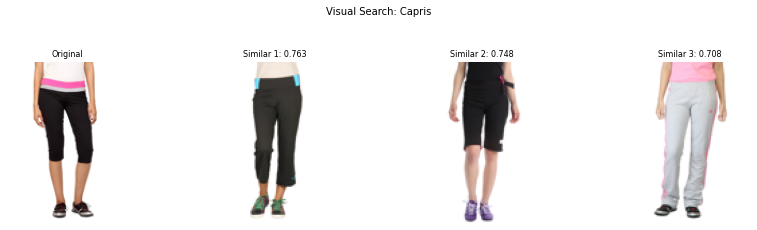

🔍 Поиск по изображению: 42002.jpg (топ-4)
    Товар: Gini and Jony Girls Kinky P...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 3/3
      ⭐ Средняя схожесть: 0.738
🔍 Поиск по изображению: 7544.jpg (топ-4)
    Товар: Nike Women Classic Grey Capri
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.759
🔍 Поиск по изображению: 46949.jpg (топ-4)
    Товар: York Women Amazing Perfume
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.738


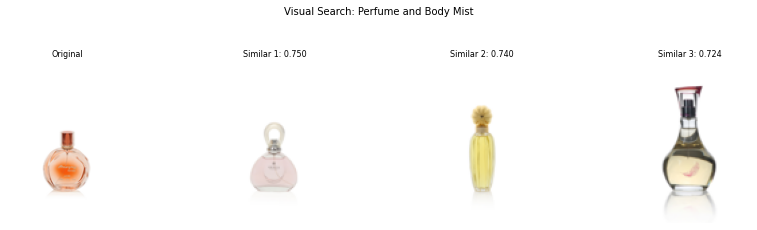

🔍 Поиск по изображению: 46766.jpg (топ-4)
    Товар: Valentino Perfumes Women 75...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.715
🔍 Поиск по изображению: 46952.jpg (топ-4)
    Товар: York Women Gracia Perfume
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.745
🔍 Поиск по изображению: 26608.jpg (топ-4)
    Товар: Puma Men Faas 800 Black Spo...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.771


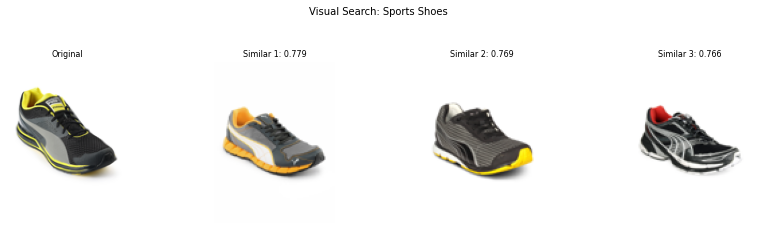

🔍 Поиск по изображению: 35937.jpg (топ-4)
    Товар: Salomon Men Techamphibian 3...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 3/3
      ⭐ Средняя схожесть: 0.721
🔍 Поиск по изображению: 37709.jpg (топ-4)
    Товар: Fila Men Black Top Fuel Spo...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 3/3
      ⭐ Средняя схожесть: 0.731
🔍 Поиск по изображению: 14859.jpg (топ-4)
    Товар: United Colors of Benetton W...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 3/3
      ⭐ Средняя схожесть: 0.780


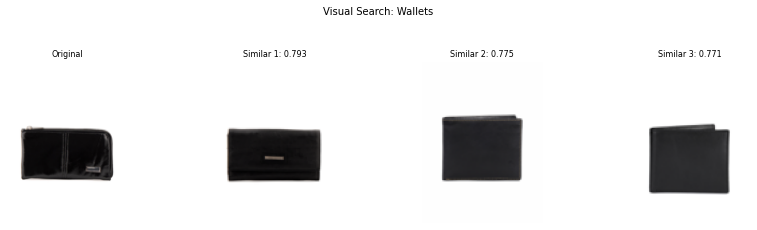

🔍 Поиск по изображению: 53376.jpg (топ-4)
    Товар: Puma Women White Ferrari Wa...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.715
🔍 Поиск по изображению: 24868.jpg (топ-4)
    Товар: Reid & Taylor Men Casual Bl...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 3/3
      ⭐ Средняя схожесть: 0.789
🔍 Поиск по изображению: 26384.jpg (топ-4)
    Товар: Turtle Men Black Trousers
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.781


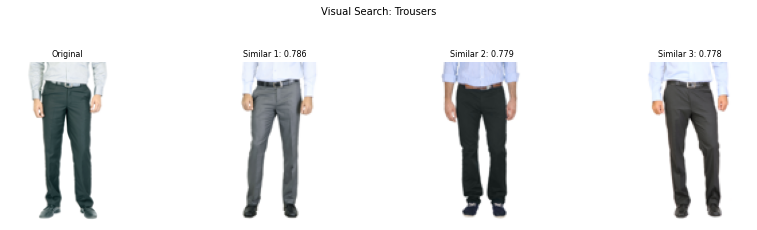

🔍 Поиск по изображению: 8937.jpg (топ-4)
    Товар: Scullers Men Scul Brown Tro...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.774
🔍 Поиск по изображению: 16609.jpg (топ-4)
    Товар: Genesis Men Stripes Grey Tr...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.786
🔍 Поиск по изображению: 44958.jpg (топ-4)
    Товар: Fogg Women Radiate Deo
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.663


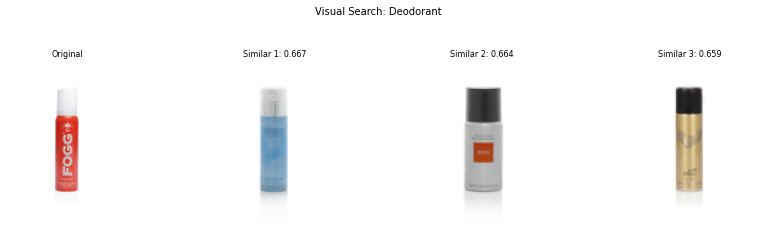

🔍 Поиск по изображению: 45768.jpg (топ-4)
    Товар: Lomani Women Deo
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.714
🔍 Поиск по изображению: 26781.jpg (топ-4)
    Товар: Reebok Men Pack of 3 Deos
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.643
🔍 Поиск по изображению: 48981.jpg (топ-4)
    Товар: Lucera Women Silver Ring
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.702


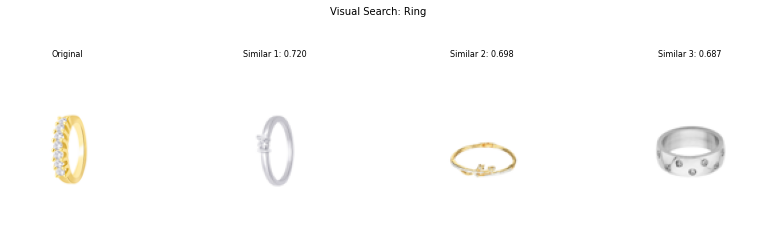

🔍 Поиск по изображению: 48948.jpg (топ-4)
    Товар: Revv Men Steel Ring
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.753
🔍 Поиск по изображению: 59457.jpg (топ-4)
    Товар: Lucera Silver Ring
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.645
🔍 Поиск по изображению: 55384.jpg (топ-4)
    Товар: Revlon Plum Deluxe Nail Ena...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.712


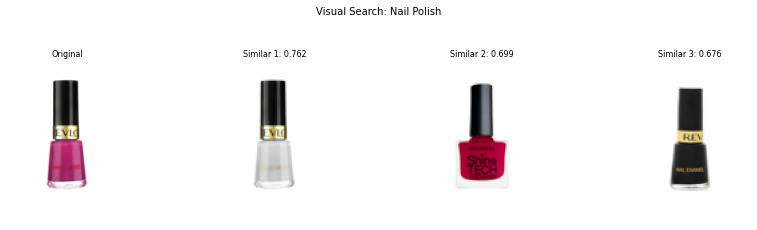

🔍 Поиск по изображению: 49125.jpg (топ-4)
    Товар: Deborah Shine Tech Ruibes N...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.697
🔍 Поиск по изображению: 57664.jpg (топ-4)
    Товар: Lotus Herbals Colour Dew Ma...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.695
🔍 Поиск по изображению: 31715.jpg (топ-4)
    Товар: Fabindia Women Anusuya Silv...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 3/3
      ⭐ Средняя схожесть: 0.721


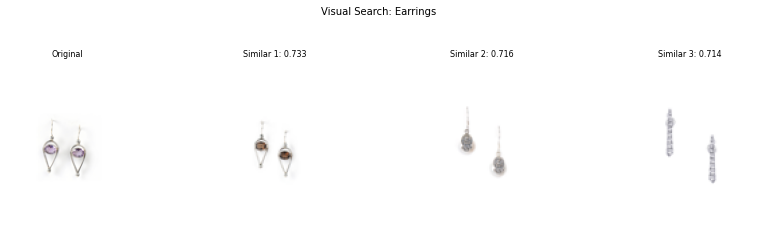

🔍 Поиск по изображению: 48636.jpg (топ-4)
    Товар: Lucera Women Silver Earrings
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 3/3
      ⭐ Средняя схожесть: 0.768
🔍 Поиск по изображению: 52823.jpg (топ-4)
    Товар: Adrika Green Earrings
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.747
🔍 Поиск по изображению: 29865.jpg (топ-4)
    Товар: Mayhem Men Aviator Sunglass...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.798


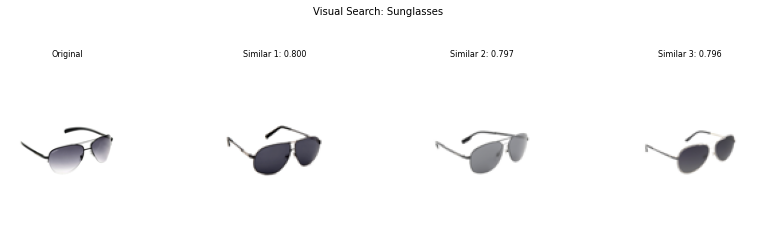

🔍 Поиск по изображению: 29892.jpg (топ-4)
    Товар: Mayhem Women Sunglasses 101...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 3/3
      ⭐ Средняя схожесть: 0.793
🔍 Поиск по изображению: 38239.jpg (топ-4)
    Товар: Polaroid Men Sunglasses
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.797
🔍 Поиск по изображению: 30463.jpg (топ-4)
    Товар: Lovable Women All Day Long ...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.756


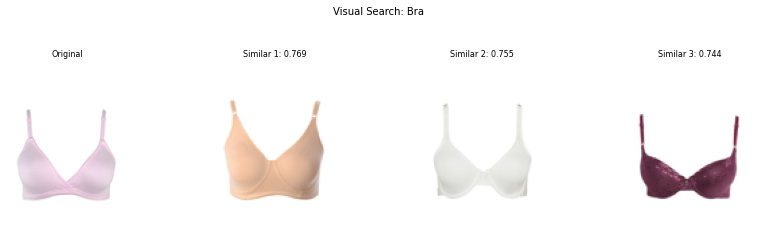

🔍 Поиск по изображению: 53490.jpg (топ-4)
    Товар: Amante Black Push-Up Bra BF...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.745
🔍 Поиск по изображению: 51006.jpg (топ-4)
    Товар: Enamor Brown Bra
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.768
🔍 Поиск по изображению: 49752.jpg (топ-4)
    Товар: Parx Men Lavender Tie
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.721


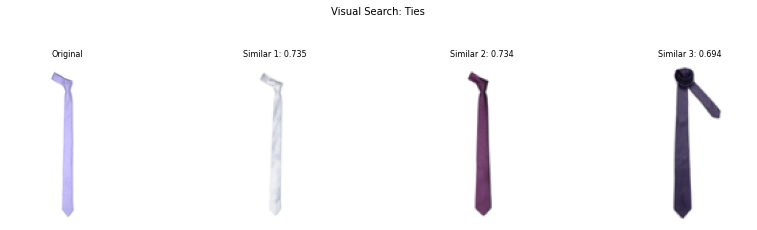

🔍 Поиск по изображению: 50287.jpg (топ-4)
    Товар: Parx Men Grey Tie
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.715
🔍 Поиск по изображению: 58894.jpg (топ-4)
    Товар: Hakashi Men Black Tie
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.755
🔍 Поиск по изображению: 39742.jpg (топ-4)
    Товар: Arrow Men Red Shoes
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.758


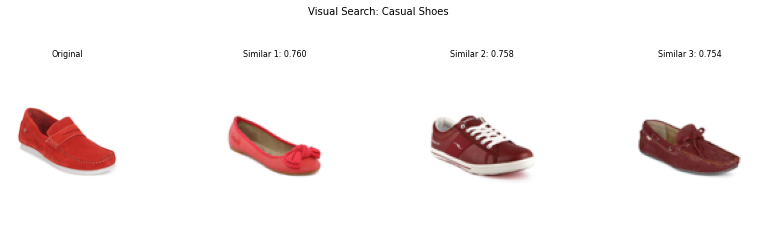

🔍 Поиск по изображению: 10305.jpg (топ-4)
    Товар: Clarks Men Rocco Fuse Brown...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.779
🔍 Поиск по изображению: 17695.jpg (топ-4)
    Товар: Vans Men Authentic Maroon C...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.759
🔍 Поиск по изображению: 21259.jpg (топ-4)
    Товар: Skybags Unisex Black Bern B...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 3/3
      ⭐ Средняя схожесть: 0.800


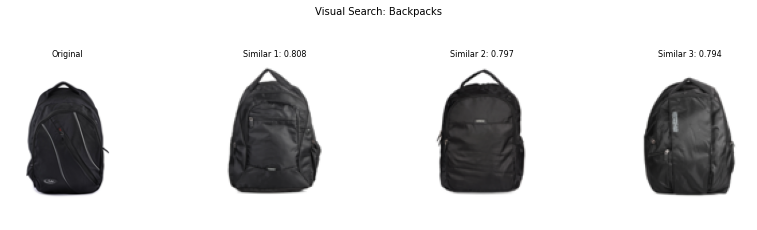

🔍 Поиск по изображению: 37694.jpg (топ-4)
    Товар: American Tourister Unisex B...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 3/3
      ⭐ Средняя схожесть: 0.788
🔍 Поиск по изображению: 25887.jpg (топ-4)
    Товар: American Tourister Unisex B...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.770
🔍 Поиск по изображению: 32766.jpg (топ-4)
    Товар: John Miller Men Striped Whi...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.776


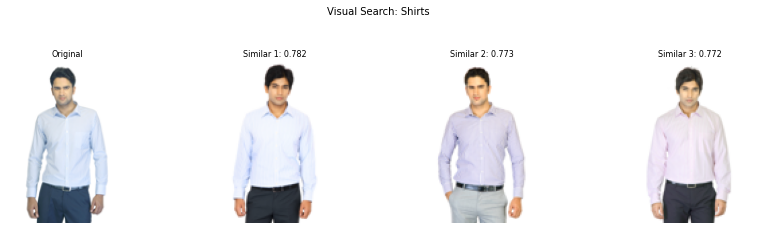

🔍 Поиск по изображению: 51424.jpg (топ-4)
    Товар: Myntra Men White Shirt
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 3/3
      ⭐ Средняя схожесть: 0.775
🔍 Поиск по изображению: 31619.jpg (топ-4)
    Товар: Indigo Nation Men Maroon Shirt
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.766
🔍 Поиск по изображению: 43217.jpg (топ-4)
    Товар: Fastrack Women Black Dial W...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 3/3
      ⭐ Средняя схожесть: 0.738


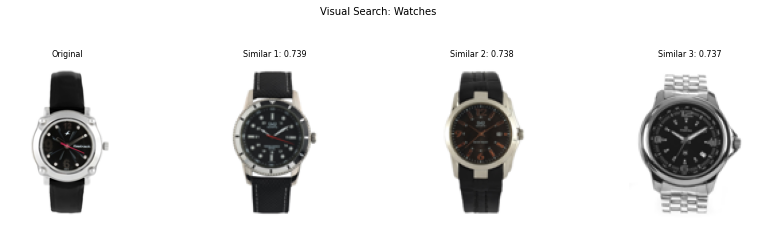

🔍 Поиск по изображению: 58449.jpg (топ-4)
    Товар: Fossil Men Black Dial Chron...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 3/3
      ⭐ Средняя схожесть: 0.746
🔍 Поиск по изображению: 40533.jpg (топ-4)
    Товар: Titan Women White Dial Watch
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.735
🔍 Поиск по изображению: 59777.jpg (топ-4)
    Товар: Estelle Women Gold Bracelet
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.698


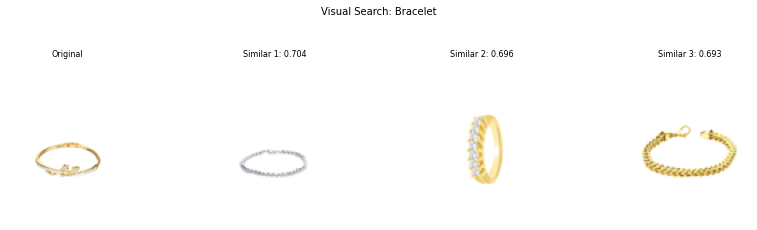

🔍 Поиск по изображению: 59553.jpg (топ-4)
    Товар: Lucera  Silver Bracelet
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.700
🔍 Поиск по изображению: 48587.jpg (топ-4)
    Товар: Lucera Women Silver Bracelet
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.735
🔍 Поиск по изображению: 6894.jpg (топ-4)
    Товар: Forever New Women Floral Mu...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.740


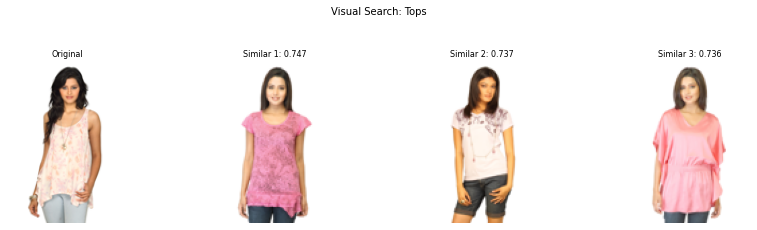

🔍 Поиск по изображению: 26902.jpg (топ-4)
    Товар: Jealous 21 Women Printed La...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.746
🔍 Поиск по изображению: 34161.jpg (топ-4)
    Товар: Gini and Jony Girls Black Top
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 3/3
      ⭐ Средняя схожесть: 0.719
🔍 Поиск по изображению: 9042.jpg (топ-4)
    Товар: Buckaroo Men Moles Brown Fo...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.776


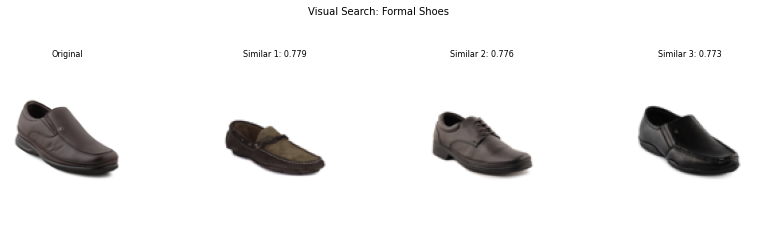

🔍 Поиск по изображению: 35657.jpg (топ-4)
    Товар: U.S. Polo Assn. Men Brown S...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.754
🔍 Поиск по изображению: 55622.jpg (топ-4)
    Товар: Numero Uno Men Brown Formal...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 3/3
      ⭐ Средняя схожесть: 0.791
🔍 Поиск по изображению: 6187.jpg (топ-4)
    Товар: ADIDAS Women's Young Lives ...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.782


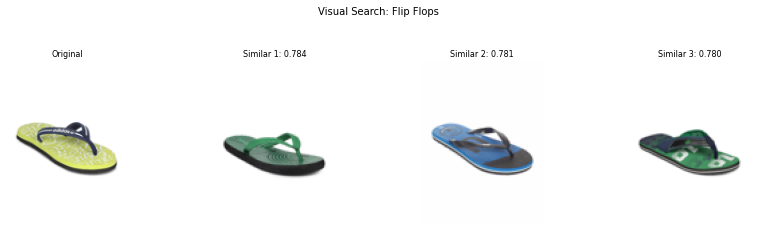

🔍 Поиск по изображению: 25449.jpg (топ-4)
    Товар: Nike Women Snapper Thong Fl...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.768
🔍 Поиск по изображению: 15849.jpg (топ-4)
    Товар: Warner Bros Kids Unisex SD ...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 3/3
      ⭐ Средняя схожесть: 0.725
🔍 Поиск по изображению: 51596.jpg (топ-4)
    Товар: Wrangler Women Black Molly ...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.752


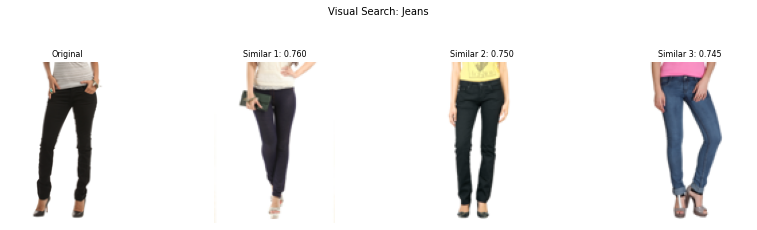

🔍 Поиск по изображению: 31672.jpg (топ-4)
    Товар: Spykar Men Blue Jeans
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.771
🔍 Поиск по изображению: 56795.jpg (топ-4)
    Товар: Horsefly Men Blue Jeans
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 3/3
      ⭐ Средняя схожесть: 0.756
🔍 Поиск по изображению: 56583.jpg (топ-4)
    Товар: Streetwear Crystal Shine Fa...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.676


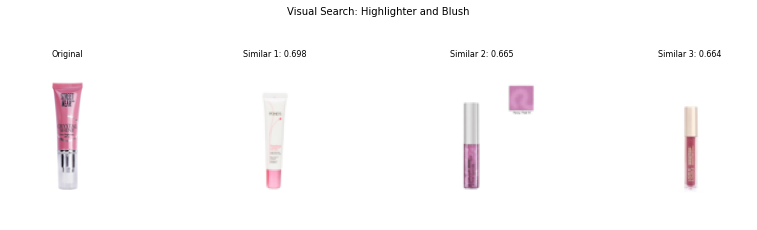

🔍 Поиск по изображению: 56614.jpg (топ-4)
    Товар: Streetwear True Color Peach...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.716
🔍 Поиск по изображению: 49154.jpg (топ-4)
    Товар: Deborah Rame HiTech Blusher...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.712
🔍 Поиск по изображению: 57264.jpg (топ-4)
    Товар: Murcia Women Black Handbag
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 3/3
      ⭐ Средняя схожесть: 0.791


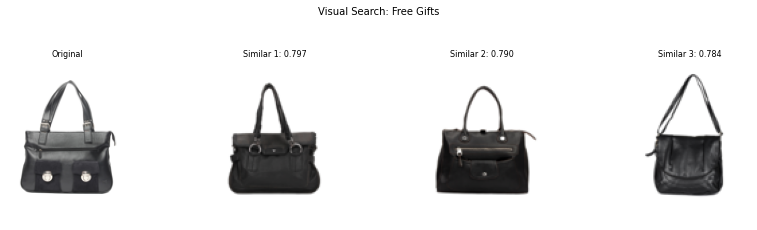

🔍 Поиск по изображению: 33637.jpg (топ-4)
    Товар: Timex Men White Dial Watch
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 3/3
      ⭐ Средняя схожесть: 0.766
🔍 Поиск по изображению: 16937.jpg (топ-4)
    Товар: Image Women Sunglasses
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.802
🔍 Поиск по изображению: 25933.jpg (топ-4)
    Товар: Femella Women Brown Scarf
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.694


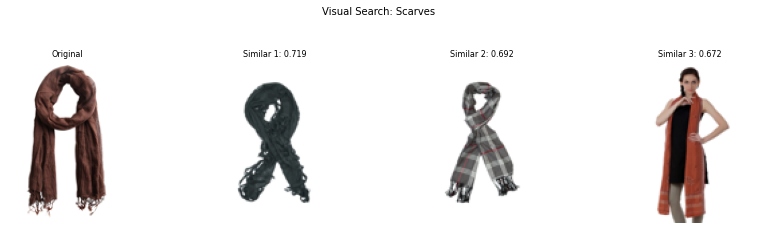

🔍 Поиск по изображению: 23487.jpg (топ-4)
    Товар: Arrow Men Grey Scarf
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.735
🔍 Поиск по изображению: 23476.jpg (топ-4)
    Товар: Lino Perros Men Grey Check ...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.670
🔍 Поиск по изображению: 40428.jpg (топ-4)
    Товар: Tonga Women Grey Formal Skirt
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.714


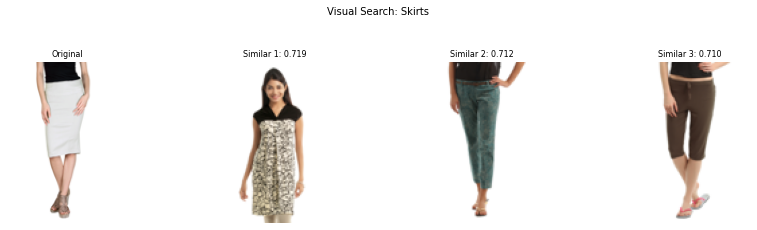

🔍 Поиск по изображению: 10002.jpg (топ-4)
    Товар: Palm Tree Kids Sp Jema Skt ...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.758
🔍 Поиск по изображению: 16805.jpg (топ-4)
    Товар: ANT Kids Girls Printed Blac...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.729
🔍 Поиск по изображению: 18499.jpg (топ-4)
    Товар: Puma Men Striped Navy Blue ...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.750


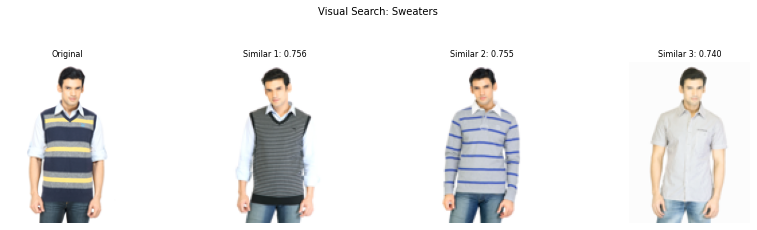

🔍 Поиск по изображению: 20218.jpg (топ-4)
    Товар: Wrangler Men Rib Charcoal S...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.754
🔍 Поиск по изображению: 22627.jpg (топ-4)
    Товар: Nike Men White Sweater
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.748
🔍 Поиск по изображению: 53377.jpg (топ-4)
    Товар: Puma Unisex Fluorescent Gre...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.712


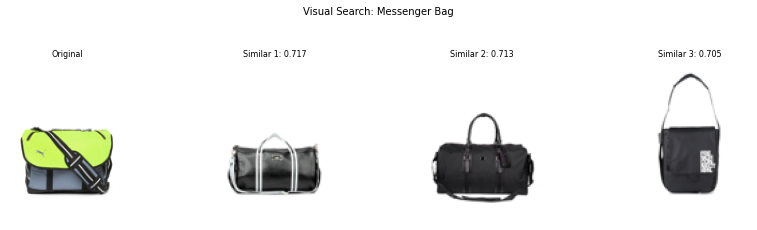

🔍 Поиск по изображению: 19911.jpg (топ-4)
    Товар: Wildcraft Unisex Grey Print...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.757
🔍 Поиск по изображению: 39875.jpg (топ-4)
    Товар: ADIDAS Unisex Brown Chelsea...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.696
🔍 Поиск по изображению: 45578.jpg (топ-4)
    Товар: Arrow Men Brown Sandals
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 3/3
      ⭐ Средняя схожесть: 0.784


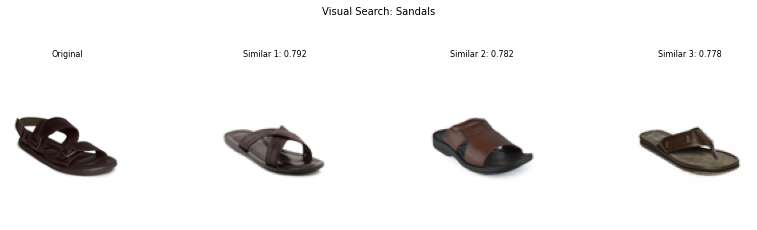

🔍 Поиск по изображению: 26546.jpg (топ-4)
    Товар: ID Men Black & Red Sandals
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.764
🔍 Поиск по изображению: 16164.jpg (топ-4)
    Товар: Enroute Men Leather Brown S...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.792
🔍 Поиск по изображению: 35786.jpg (топ-4)
    Товар: Enroute Women Bluish Grey S...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 3/3
      ⭐ Средняя схожесть: 0.770


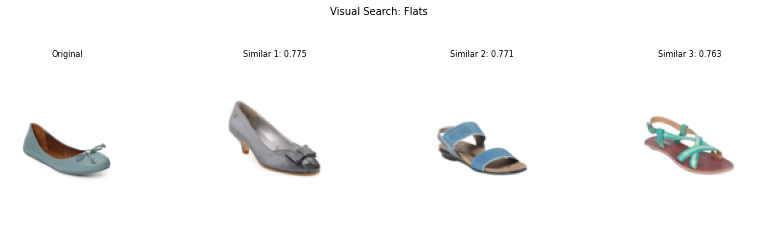

🔍 Поиск по изображению: 11504.jpg (топ-4)
    Товар: Catwalk Women Black Flats
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.780
🔍 Поиск по изображению: 16994.jpg (топ-4)
    Товар: Rocia Women Casual Black Heels
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.768
🔍 Поиск по изображению: 57727.jpg (топ-4)
    Товар: Lotus Herbals Seduction Cra...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.774


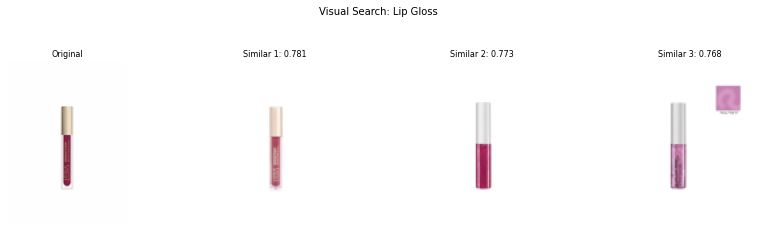

🔍 Поиск по изображению: 56078.jpg (топ-4)
    Товар: Colorbar Star Shine Bewitch...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.774
🔍 Поиск по изображению: 56091.jpg (топ-4)
    Товар: Colorbar Star Shine Fancy T...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.754
🔍 Поиск по изображению: 12107.jpg (топ-4)
    Товар: W Women Cream Kurtis
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.749


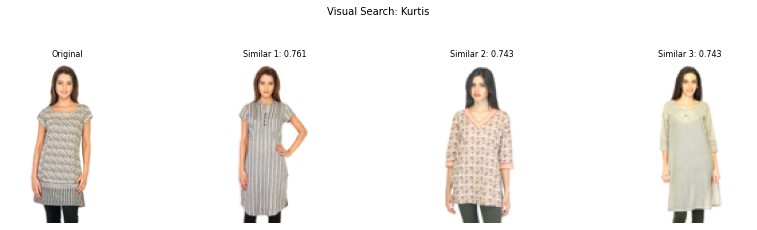

🔍 Поиск по изображению: 18303.jpg (топ-4)
    Товар: Aneri Women Kavita Maroon K...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.751
🔍 Поиск по изображению: 12151.jpg (топ-4)
    Товар: Aurelia Women Printed Pink ...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.769
🔍 Поиск по изображению: 39871.jpg (топ-4)
    Товар: Catwalk Women Blue Flats
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.758


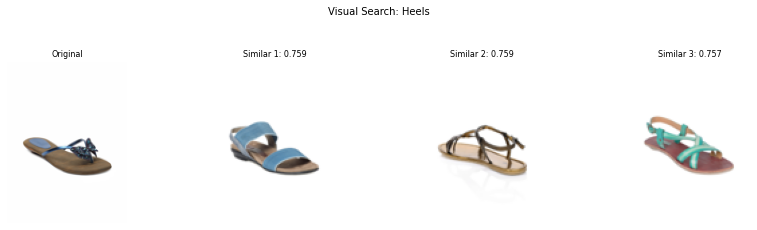

🔍 Поиск по изображению: 50164.jpg (топ-4)
    Товар: Rocia Women White Wedges
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 3/3
      ⭐ Средняя схожесть: 0.764
🔍 Поиск по изображению: 20775.jpg (топ-4)
    Товар: Carlton London Women Classy...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.762
🔍 Поиск по изображению: 51158.jpg (топ-4)
    Товар: Raymond Men Brown Socks
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.776


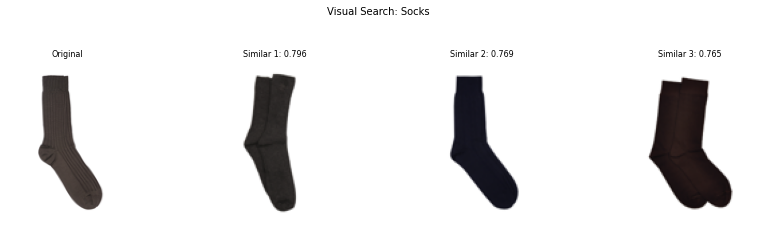

🔍 Поиск по изображению: 31999.jpg (топ-4)
    Товар: Playboy Men Cream Socks
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.701
🔍 Поиск по изображению: 8503.jpg (топ-4)
    Товар: Nike Unisex China Swsh Ct W...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.707
🔍 Поиск по изображению: 16221.jpg (топ-4)
    Товар: Puma Men Heroes Black Track...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.764


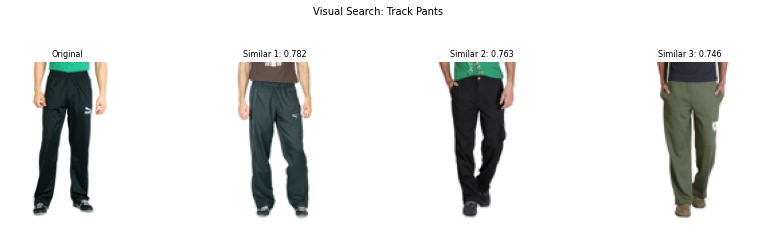

🔍 Поиск по изображению: 32644.jpg (топ-4)
    Товар: Nike Men Knit Black Track P...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.790
🔍 Поиск по изображению: 53747.jpg (топ-4)
    Товар: ADIDAS Men Black Track Pant
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.757
🔍 Поиск по изображению: 57588.jpg (топ-4)
    Товар: Lotus Herbals Cinnamon Lips...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.708


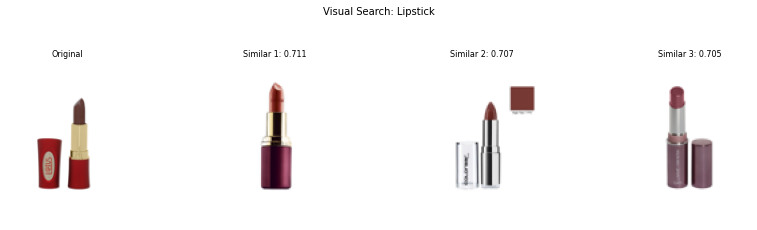

🔍 Поиск по изображению: 55973.jpg (топ-4)
    Товар: ColorBar Velvet Matte High ...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.753
🔍 Поиск по изображению: 55057.jpg (топ-4)
    Товар: Lakme Enrich Satins Lipstic...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.741
🔍 Поиск по изображению: 25599.jpg (топ-4)
    Товар: Vishudh Women Grey & Black ...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.757


🔍 Поиск по изображению: 28966.jpg (топ-4)
    Товар: Biba Women Blue Printed Sal...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.766
🔍 Поиск по изображению: 39139.jpg (топ-4)
    Товар: Aneri Women White & Black P...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.756
🔍 Поиск по изображению: 42863.jpg (топ-4)
    Товар: 42863
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.723


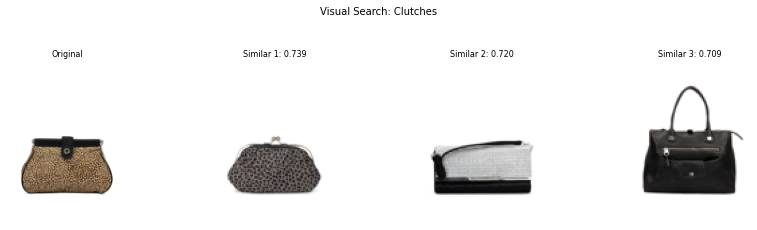

🔍 Поиск по изображению: 21982.jpg (топ-4)
    Товар: Murcia Women Casual Gold Cl...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.750
🔍 Поиск по изображению: 25122.jpg (топ-4)
    Товар: Lino Perros Women Gems Blac...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 3/3
      ⭐ Средняя схожесть: 0.744
🔍 Поиск по изображению: 13578.jpg (топ-4)
    Товар: Hanes Men Pack of 2 Half Co...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.722


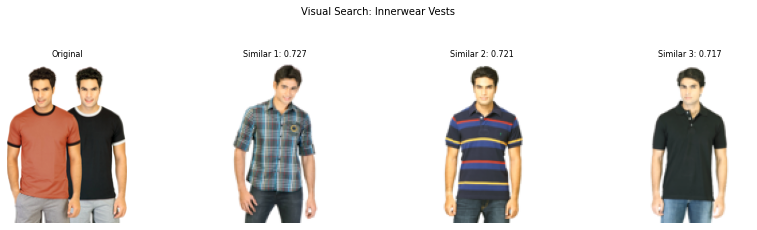

🔍 Поиск по изображению: 45665.jpg (топ-4)
    Товар: Park Avenue Men White Inner...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.702
🔍 Поиск по изображению: 50498.jpg (топ-4)
    Товар: Chromozome Men Maroon Inner...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.727
🔍 Поиск по изображению: 15029.jpg (топ-4)
    Товар: ADIDAS Women Stripes Purple...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.728


🔍 Поиск по изображению: 18962.jpg (топ-4)
    Товар: United Colors of Benetton W...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.711
🔍 Поиск по изображению: 13289.jpg (топ-4)
    Товар: Gini and Jony Kids Boys Pri...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.668
🔍 Поиск по изображению: 28640.jpg (топ-4)
    Товар: Nike Men Victor Woven Black...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.769


🔍 Поиск по изображению: 3507.jpg (топ-4)
    Товар: ADIDAS Men's Cont Black Short
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.775
🔍 Поиск по изображению: 54925.jpg (топ-4)
    Товар: Do U Speak Green Men Cream ...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.741
🔍 Поиск по изображению: 57053.jpg (топ-4)
    Товар: Elle Pink Vintage Dress
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.736


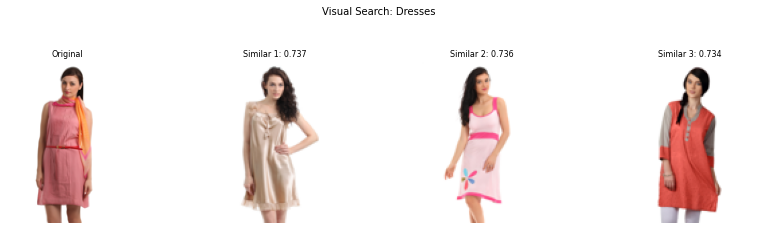

🔍 Поиск по изображению: 57998.jpg (топ-4)
    Товар: Latin Quarters Women Blue D...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.723
🔍 Поиск по изображению: 48486.jpg (топ-4)
    Товар: French Connection Women Gre...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.728
🔍 Поиск по изображению: 52981.jpg (топ-4)
    Товар: FNF Green Printed Sari
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.760


🔍 Поиск по изображению: 52925.jpg (топ-4)
    Товар: FNF Lavender Sari
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.735
🔍 Поиск по изображению: 52945.jpg (топ-4)
    Товар: FNF Printed Black Sari
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.774
🔍 Поиск по изображению: 34938.jpg (топ-4)
    Товар: Fabindia Off White Chanderi...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.762


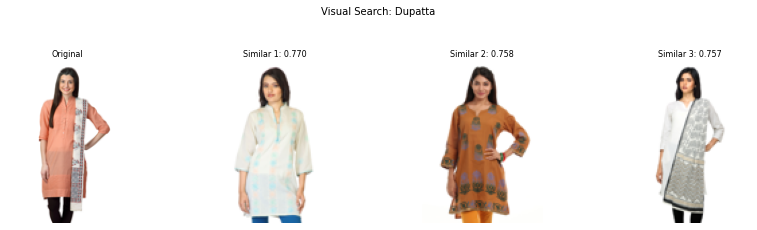

🔍 Поиск по изображению: 34271.jpg (топ-4)
    Товар: Fabindia Women Printed Off ...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.763
🔍 Поиск по изображению: 31061.jpg (топ-4)
    Товар: Fabindia Women Rust Dupatta
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.727
🔍 Поиск по изображению: 32533.jpg (топ-4)
    Товар: Playboy Men Hollywood Fragr...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.672


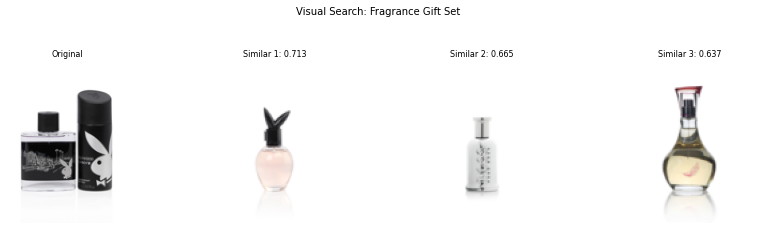

🔍 Поиск по изображению: 23589.jpg (топ-4)
    Товар: Nike Fragrances Women Urban...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.736
🔍 Поиск по изображению: 23620.jpg (топ-4)
    Товар: Nike Fragrances Men Blue Bl...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.701
🔍 Поиск по изображению: 17374.jpg (топ-4)
    Товар: Arrow Men Formal Purple Tie...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.696


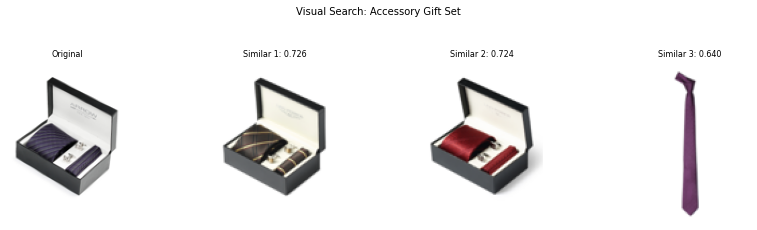

🔍 Поиск по изображению: 25062.jpg (топ-4)
    Товар: Lino Perros Men Formal Brow...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.688
🔍 Поиск по изображению: 25075.jpg (топ-4)
    Товар: Lino Perros Men Formal Maro...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.700
🔍 Поиск по изображению: 39058.jpg (топ-4)
    Товар: Belmonte Men Steel Button C...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.712


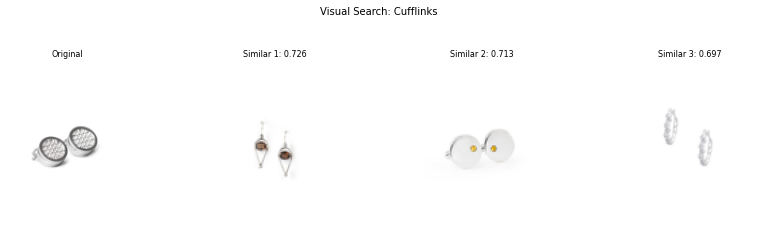

🔍 Поиск по изображению: 59584.jpg (топ-4)
    Товар: Revv Men Black Cufflinks
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.711
🔍 Поиск по изображению: 59577.jpg (топ-4)
    Товар: Revv Men Steel and Brown Cu...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.683
🔍 Поиск по изображению: 36753.jpg (топ-4)
    Товар: Little Miss Girls Chatterbo...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.715


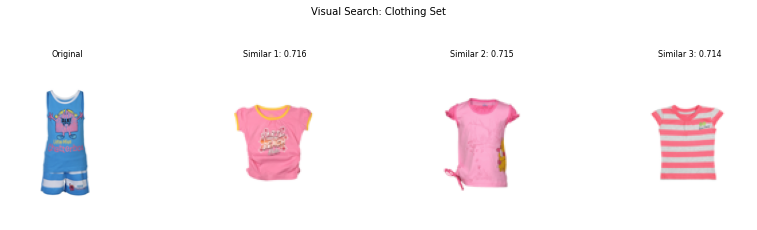

🔍 Поиск по изображению: 36747.jpg (топ-4)
    Товар: Mr.Men Boys I Am Sleeping W...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.682
🔍 Поиск по изображению: 36752.jpg (топ-4)
    Товар: Little Miss Girls Blazing Y...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.684
🔍 Поиск по изображению: 46243.jpg (топ-4)
    Товар: Fusion Beats Women White & ...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.749


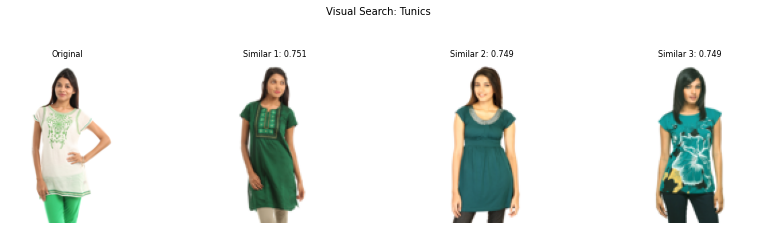

🔍 Поиск по изображению: 15079.jpg (топ-4)
    Товар: Mother Earth Women Printed ...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.711
🔍 Поиск по изображению: 7212.jpg (топ-4)
    Товар: Scullers For Her Women Laye...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.732
🔍 Поиск по изображению: 54881.jpg (топ-4)
    Товар: Ivory Tag Women Sparkling C...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.745


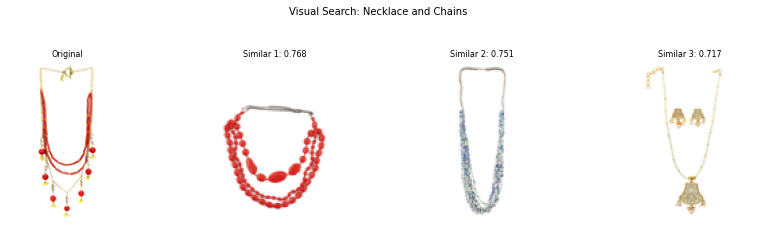

🔍 Поиск по изображению: 52308.jpg (топ-4)
    Товар: ToniQ Women Multi Coloured ...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.680
🔍 Поиск по изображению: 14863.jpg (топ-4)
    Товар: United Colors of Benetton W...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.741
🔍 Поиск по изображению: 56235.jpg (топ-4)
    Товар: SDL by Sweet Dreams Men Whi...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.708


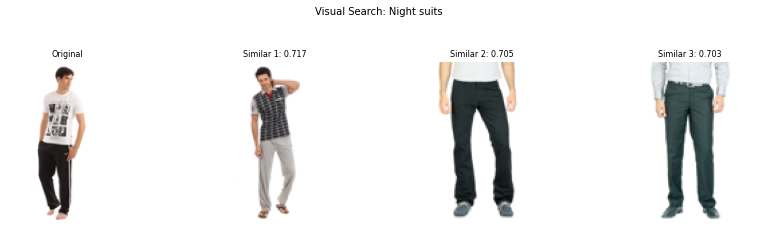

🔍 Поиск по изображению: 36273.jpg (топ-4)
    Товар: SDL by Sweet Dreams Women P...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 3/3
      ⭐ Средняя схожесть: 0.732
🔍 Поиск по изображению: 55814.jpg (топ-4)
    Товар: SDL by Sweet Dreams Women P...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.717
🔍 Поиск по изображению: 21254.jpg (топ-4)
    Товар: Skybags Unisex Maroon Duffl...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.741


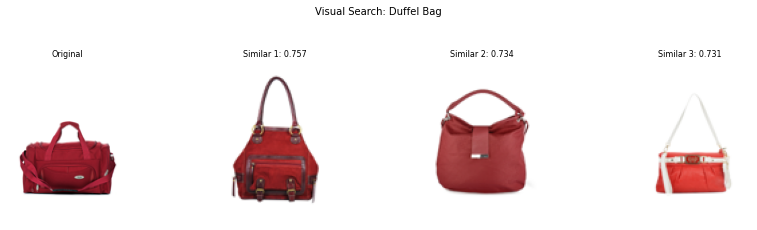

🔍 Поиск по изображению: 36068.jpg (топ-4)
    Товар: OTLS Unisex Khaki Duffle Bag
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.767
🔍 Поиск по изображению: 39504.jpg (топ-4)
    Товар: Peter England Unisex Black ...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 3/3
      ⭐ Средняя схожесть: 0.768
🔍 Поиск по изображению: 43705.jpg (топ-4)
    Товар: Royal Diadem White Jeweller...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.734


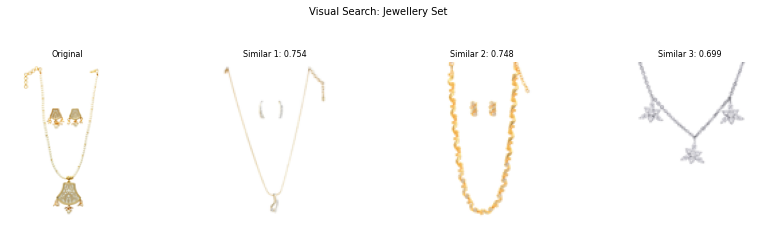

🔍 Поиск по изображению: 42610.jpg (топ-4)
    Товар: Estelle Women Gold Jeweller...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.712
🔍 Поиск по изображению: 59769.jpg (топ-4)
    Товар: Estelle Women Gold Earring ...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 2/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.721
🔍 Поиск по изображению: 37556.jpg (топ-4)
    Товар: Madagascar 3 Infant Girls L...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.728


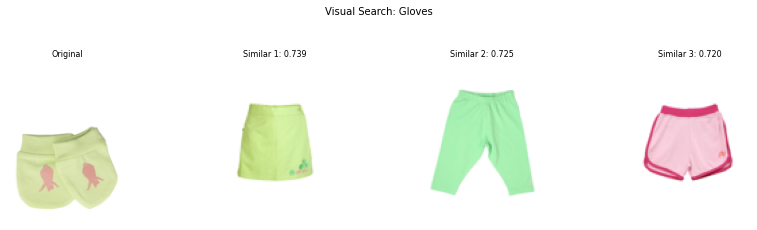

🔍 Поиск по изображению: 37540.jpg (топ-4)
    Товар: Madagascar 3 Infant Boys Ye...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.687
🔍 Поиск по изображению: 19544.jpg (топ-4)
    Товар: United Colors of Benetton M...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.652
🔍 Поиск по изображению: 35338.jpg (топ-4)
    Товар: Fabindia Women Anusuya Gree...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.716


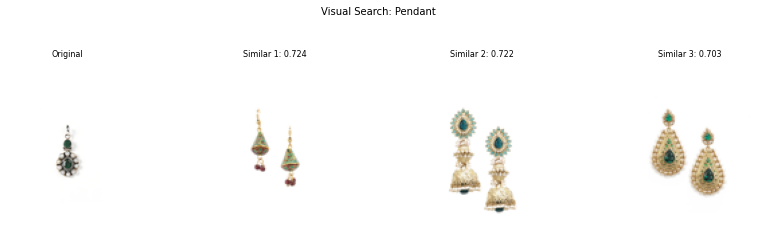

🔍 Поиск по изображению: 48810.jpg (топ-4)
    Товар: Revv Men Steel Pendant
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.705
🔍 Поиск по изображению: 48882.jpg (топ-4)
    Товар: Lucera Women Silver Pendant...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 3/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.735
🔍 Поиск по изображению: 55317.jpg (топ-4)
    Товар: Revlon Touch & Glow Advance...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.581


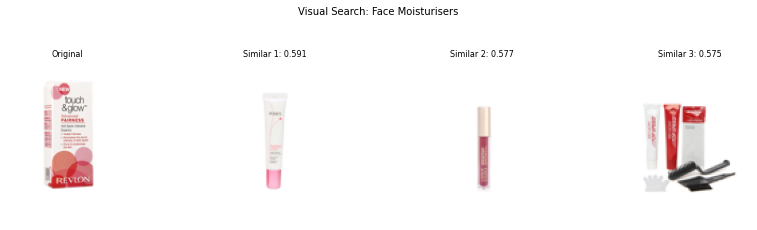

🔍 Поиск по изображению: 57871.jpg (топ-4)
    Товар: Biotique Botanicals Ayurved...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.704
🔍 Поиск по изображению: 55099.jpg (топ-4)
    Товар: Pond's Women Gold Radiance ...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 1/3
      ⭐ Средняя схожесть: 0.693
🔍 Поиск по изображению: 31895.jpg (топ-4)
    Товар: Fabindia Women Magenta Noil...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.745


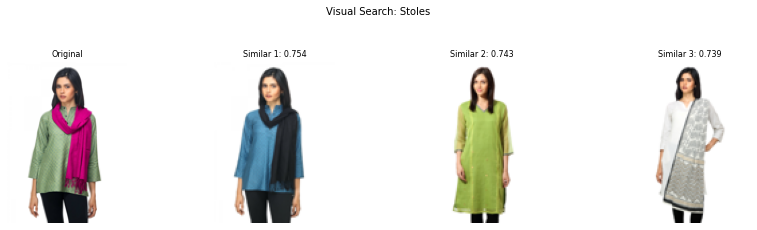

🔍 Поиск по изображению: 31894.jpg (топ-4)
    Товар: Fabindia Women Black Noil S...
      ✅ Найдено похожих: 3
      🎯 В той же категории: 1/3
      🎨 Того же цвета: 0/3
      ⭐ Средняя схожесть: 0.745
🔍 Поиск по изображению: 31881.jpg (топ-4)
    Товар: Fabindia Women Blue Stole
      ✅ Найдено похожих: 3
      🎯 В той же категории: 0/3
      🎨 Того же цвета: 2/3
      ⭐ Средняя схожесть: 0.689

📊 СВОДКА ПО РЕЗУЛЬТАТАМ ВИЗУАЛЬНОГО ПОИСКА:


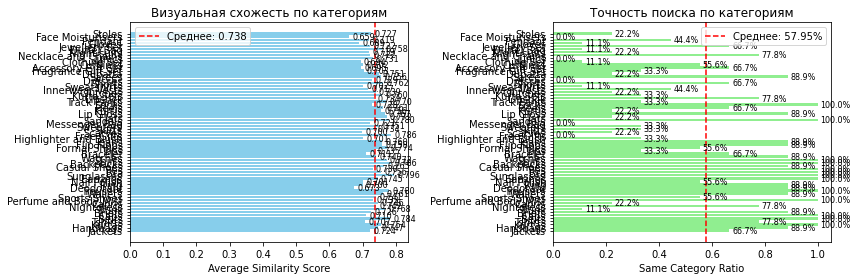


 ОБЩАЯ СТАТИСТИКА:
   • Средняя визуальная схожесть: 0.738
   • Средняя точность по категориям: 57.95%
   • Протестировано категорий: 65
   • Всего протестировано товаров: 195

 ЛУЧШИЕ КАТЕГОРИИ ПО СХОЖЕСТИ:
   • Sunglasses: 0.796
   • Free Gifts: 0.786
   • Backpacks: 0.786

 КАТЕГОРИИ ДЛЯ УЛУЧШЕНИЯ:
   • Face Moisturisers: 0.659
   • Deodorant: 0.673
   • Gloves: 0.689


In [18]:
def test_visual_similarity(search_engine, test_cases=None):
    """Тестирование визуального поиска похожих товаров"""
    
    if test_cases is None:
        
        test_cases = []
        
        if search_engine.image_paths:
          
            categories = {}
            
            for product_id, metadata in search_engine.metadata.items():
                if product_id in search_engine.image_paths:
                    category = metadata.get('article_type', 'Unknown')
                    if not isinstance(category, str):
                        category = str(category)
                    if category not in categories:
                        categories[category] = []
                    categories[category].append(product_id)
            
            # Создаем тестовые случаи для каждой категории
            for category, product_ids in categories.items():
                if len(product_ids) >= 3:  
                    test_cases.append({
                        'category': category,
                        'test_products': product_ids[:3], 
                        'description': f"Поиск похожих товаров в категории: {category}"
                    })
   
    results_summary = []
    
    for i, test_case in enumerate(test_cases, 1):
        
        category_results = []
        
        for product_id in test_case['test_products']:
            if product_id in search_engine.image_paths:
                img_path = search_engine.image_paths[product_id]
                
                if Path(img_path).exists():
                    original_meta = search_engine.metadata.get(product_id, {})
                    
                    display_name = original_meta.get('display_name', '')
                    if not isinstance(display_name, str):
                        if pd.isna(display_name):
                            display_name = str(product_id)
                        else:
                            display_name = str(display_name)
                    
                    # Ищем похожие товары по изображению
                    similar_results = search_engine.search_by_image(img_path, top_k=4)
                    
                    if similar_results:
                        # Отфильтровываем сам товар из результатов
                        similar_filtered = [r for r in similar_results if r['product_id'] != product_id]
                        
                        if similar_filtered:
                            # Анализируем насколько похожи найденные товары
                            same_category_count = 0
                            same_color_count = 0
                            
                            for result in similar_filtered:
                                result_meta = result['metadata']
                                
                                original_category = original_meta.get('article_type', 'Unknown')
                                result_category = result_meta.get('article_type', 'Unknown')
                                
                                if isinstance(original_category, str) and isinstance(result_category, str):
                                    if original_category == result_category:
                                        same_category_count += 1
                                elif pd.isna(original_category) and pd.isna(result_category):
                                    same_category_count += 1
                                
                                original_color = original_meta.get('color', 'Unknown')
                                result_color = result_meta.get('color', 'Unknown')
                                
                                if isinstance(original_color, str) and isinstance(result_color, str):
                                    if original_color == result_color:
                                        same_color_count += 1
                                elif pd.isna(original_color) and pd.isna(result_color):
                                    same_color_count += 1
                            
                            category_results.append({
                                'original_id': product_id,
                                'original_name': display_name,
                                'similar_found': len(similar_filtered),
                                'same_category': same_category_count,
                                'same_color': same_color_count,
                                'avg_similarity': np.mean([r['similarity'] for r in similar_filtered]) if similar_filtered else 0
                            })
                            
                            # Безопасный вывод названия (обрезаем до 30 символов если это строка)
                            safe_display_name = str(display_name)
                            if len(safe_display_name) > 30:
                                safe_display_name = safe_display_name[:27] + "..."
                            
                            print(f"    Товар: {safe_display_name}")
                            print(f"      ✅ Найдено похожих: {len(similar_filtered)}")
                            print(f"      🎯 В той же категории: {same_category_count}/{len(similar_filtered)}")
                            print(f"      🎨 Того же цвета: {same_color_count}/{len(similar_filtered)}")
                            print(f"      ⭐ Средняя схожесть: {np.mean([r['similarity'] for r in similar_filtered]):.3f}")
                            
                            # Визуализация для первого товара в каждой категории
                            if product_id == test_case['test_products'][0] and len(similar_filtered) >= 3:
                                try:
                                    # Создаем визуализацию
                                    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
                                    
                                    # Исходное изображение
                                    original_img = Image.open(img_path).convert('RGB')
                                    original_img.thumbnail((150, 150))
                                    axes[0].imshow(original_img)
                                    axes[0].set_title("Original", fontsize=8)
                                    axes[0].axis('off')
                                    
                                    # Три самых похожих
                                    for idx, result in enumerate(similar_filtered[:3], 1):
                                        result_img = search_engine.get_product_image(
                                            result['product_id'], size=(120, 120)
                                        )
                                        axes[idx].imshow(result_img)
                                        score = result['similarity']
                                        axes[idx].set_title(f"Similar {idx}: {score:.3f}", fontsize=8)
                                        axes[idx].axis('off')
                                    
                                    plt.suptitle(f"Visual Search: {test_case['category']}", fontsize=10, y=1.05)
                                    plt.tight_layout()
                                    plt.show()
                                except Exception as e:
                                    print(f"       Ошибка визуализации: {e}")
        
        if category_results:
            # Сводка по категории
            avg_similarity = np.mean([r['avg_similarity'] for r in category_results])
            avg_same_category = np.mean([r['same_category'] for r in category_results])
            
            results_summary.append({
                'category': test_case['category'],
                'avg_similarity': avg_similarity,
                'avg_same_category': avg_same_category,
                'tested_products': len(category_results)
            })
    
    return results_summary

# Запускаем тестирование визуального поиска
if search_engine.index is not None and search_engine.image_paths:
    visual_results = test_visual_similarity(search_engine)
    
    # Анализ результатов
    if visual_results:
        print("\n📊 СВОДКА ПО РЕЗУЛЬТАТАМ ВИЗУАЛЬНОГО ПОИСКА:")
    
        results_df = pd.DataFrame(visual_results)
        
        # Визуализация результатов
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        # График средней схожести по категориям
        categories = results_df['category'].astype(str)
        similarities = results_df['avg_similarity']
        
        bars1 = axes[0].barh(categories, similarities, color='skyblue')
        axes[0].set_xlabel('Average Similarity Score')
        axes[0].set_title('Визуальная схожесть по категориям')
        axes[0].axvline(results_df['avg_similarity'].mean(), color='red', linestyle='--', 
                       label=f'Среднее: {results_df["avg_similarity"].mean():.3f}')
        
        # Добавляем значения на бары
        for bar, val in zip(bars1, similarities):
            axes[0].text(val + 0.01, bar.get_y() + bar.get_height()/2, 
                        f'{val:.3f}', va='center', fontsize=8)
        
        # График точности по категориям
        same_category_ratio = results_df['avg_same_category'] / 3  
        
        bars2 = axes[1].barh(categories, same_category_ratio, color='lightgreen')
        axes[1].set_xlabel('Same Category Ratio')
        axes[1].set_title('Точность поиска по категориям')
        axes[1].axvline(same_category_ratio.mean(), color='red', linestyle='--',
                       label=f'Среднее: {same_category_ratio.mean():.2%}')
        
        # Добавляем значения на бары
        for bar, val in zip(bars2, same_category_ratio):
            axes[1].text(val + 0.01, bar.get_y() + bar.get_height()/2,
                        f'{val:.1%}', va='center', fontsize=8)
        
        axes[0].legend()
        axes[1].legend()
        plt.tight_layout()
        plt.show()
        
        # Статистика
        print(f"\n ОБЩАЯ СТАТИСТИКА:")
        print(f"   • Средняя визуальная схожесть: {results_df['avg_similarity'].mean():.3f}")
        print(f"   • Средняя точность по категориям: {same_category_ratio.mean():.2%}")
        print(f"   • Протестировано категорий: {len(results_df)}")
        print(f"   • Всего протестировано товаров: {results_df['tested_products'].sum()}")
        
        # Лучшие и худшие категории
        print(f"\n ЛУЧШИЕ КАТЕГОРИИ ПО СХОЖЕСТИ:")
        best_categories = results_df.nlargest(3, 'avg_similarity')
        for _, row in best_categories.iterrows():
            print(f"   • {row['category']}: {row['avg_similarity']:.3f}")
        
        print(f"\n КАТЕГОРИИ ДЛЯ УЛУЧШЕНИЯ:")
        worst_categories = results_df.nsmallest(3, 'avg_similarity')
        for _, row in worst_categories.iterrows():
            print(f"   • {row['category']}: {row['avg_similarity']:.3f}")
else:
    print(" Система не готова для тестирования визуального поиска")